<a href="https://colab.research.google.com/github/halduaij/inverter/blob/main/Per_unitInverter_control_pytorch_5_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.optimize import fsolve, root, least_squares, newton_krylov

def super_safe_solve(F, x0,
                     jac=None,
                     scale=None,
                     tol=1e-8,
                     maxfev=40000,
                     methods=("fsolve","hybr","trf","krylov"),
                     n_multistart=3,
                     multistart_radius=1e-1):
    """
    Try many root‐finding strategies in turn, with optional scaling
    and multi‐start.

    Parameters
    ----------
    F      : callable F(x) -> shape (n,)
    x0     : initial guess array, shape (n,)
    jac    : callable J(x)->(n,n) or None
    scale  : array of length n for variable scaling, or None
    tol    : required residual norm
    maxfev : max function evals for fsolve / least_squares
    methods: tuple of methods to try in order:
             'fsolve' -> scipy.optimize.fsolve
             'hybr'   -> scipy.optimize.root(method='hybr')
             'trf'    -> scipy.optimize.least_squares(method='trf')
             'krylov' -> scipy.optimize.newton_krylov
    n_multistart : how many random starting points if all methods fail
    multistart_radius : spread for random restarts around x0
    """
    # 1) handle scaling
    if scale is None:
        scale = np.ones_like(x0)
    invscale = 1.0/scale

    def G(u):
        x = invscale * u
        return scale * F(x)

    def g_jac(u):
        x = invscale * u
        Jx = jac(x)
        # chain‐rule: dG/du = scale * Jx * diag(invscale)
        return (scale[:,None] * Jx) * invscale[None,:]

    # helper to test solution
    def test_solution(x):
        res = np.linalg.norm(F(x))
        return res < tol, res

    # 2) try each method once
    for method in methods:
        try:
            if method == "fsolve":
                sol, info, ier, msg = fsolve(
                    G, scale*x0,
                    fprime=(g_jac if jac else None),
                    full_output=True,
                    maxfev=maxfev
                )
                x_hat = invscale * sol
                ok, res = test_solution(x_hat)

            elif method == "hybr":
                out = root(G, scale*x0, jac=(g_jac if jac else None),
                           method="hybr", options={"maxfev": maxfev})
                x_hat = invscale * out.x
                ok, res = (out.success, np.linalg.norm(F(x_hat)))

            elif method == "trf":
                out = least_squares(
                    G, scale*x0,
                    jac=(g_jac if jac else '2-point'),
                    ftol=tol, xtol=tol,
                    max_nfev=maxfev,
                    method="trf"
                )
                x_hat = invscale * out.x
                ok, res = (out.success, np.linalg.norm(F(x_hat)))

            elif method == "krylov":
                sol = newton_krylov(G, scale*x0, f_tol=tol, maxiter=100)
                x_hat = invscale * sol
                ok, res = test_solution(x_hat)

            else:
                continue

            if ok:
                return x_hat, True, res, f"Converged with {method}"

        except Exception as e:
            # ignore and try next
            pass

    # 3) multi‑start around x0
    for i in range(n_multistart):
        x0p = x0 + multistart_radius * np.random.randn(*x0.shape)
        try:
            sol, info, ier, msg = fsolve(
                G, scale*x0p,
                fprime=(g_jac if jac else None),
                full_output=True,
                maxfev=maxfev
            )
            x_hat = invscale * sol
            ok, res = test_solution(x_hat)
            if ok:
                return x_hat, True, res, f"Converged with fsolve after {i+1} restarts"
        except:
            continue

    # 4) give up
    return None, False, None, "All methods failed to converge"


In [ ]:
pip install SaLSa-Optimizer

In [ ]:
from salsa.SaLSA import SaLSA


In [ ]:
# pcgrad.py  (stand‑alone, MIT licence)
import torch
from torch.optim.optimizer import Optimizer

class PCGrad(Optimizer):
    """Projection Conflicting Gradients (Yu et al., NeurIPS 2020).
    Wrap any torch Optimizer   →  same API plus .pc_backward(loss_list)."""

    def __init__(self, optimizer: Optimizer):
        self._optim = optimizer
        self.param_groups = self._optim.param_groups
        self.defaults     = self._optim.defaults
        self.state        = self._optim.state

    # --- thin pass‑throughs --------------------------------------------
    def zero_grad(self, *a, **kw): return self._optim.zero_grad(*a, **kw)
    def step     (self, *a, **kw): return self._optim.step(*a, **kw)

    # --- helpers -------------------------------------------------------
    def _flat_grads(self):
        return [p.grad.detach().clone() if p.grad is not None else None
                for g in self.param_groups for p in g['params']]

    def _write_grads(self, new):
        k = 0
        for g in self.param_groups:
            for p in g['params']:
                p.grad = None if new[k] is None else new[k]
                k += 1

    # --- core ----------------------------------------------------------
    @torch.no_grad()
    def pc_backward(self, losses, retain_graph=False):
        if not isinstance(losses, (list, tuple)):
            losses = [losses]

        # collect gradients for each loss
        task_grads = []
        for i, L in enumerate(losses):
            L.backward(retain_graph=(i < len(losses)-1) or retain_graph)
            task_grads.append(self._flat_grads())
            self.zero_grad(set_to_none=True)

        # project pairwise conflicts
        n_tasks, n_params = len(task_grads), len(task_grads[0])
        merged = [torch.zeros_like(g) if g is not None else None
                  for g in task_grads[0]]

        for t in range(n_tasks):
            g_t = task_grads[t]
            for p in range(n_params):
                if g_t[p] is None: continue
                v = g_t[p].clone()
                for s in range(n_tasks):
                    if s == t or task_grads[s][p] is None: continue
                    g_s = task_grads[s][p]
                    dot = torch.dot(v.view(-1), g_s.view(-1))
                    if dot < 0:
                        v -= dot / (g_s.view(-1).pow(2).sum() + 1e-12) * g_s
                merged[p] = merged[p] + v / n_tasks

        self._write_grads(merged)


In [ ]:
!pip install git+https://github.com/halduaij/torchdiffeq.git


  Cloning https://github.com/halduaij/torchdiffeq.git to /tmp/pip-req-build-gxcbgndf
  Running command git clone --filter=blob:none --quiet https://github.com/halduaij/torchdiffeq.git /tmp/pip-req-build-gxcbgndf
  Resolved https://github.com/halduaij/torchdiffeq.git to commit 6f4c3a4eab4b2ce54a1f7d818c72ac751e6f2c27
  Preparing metadata (setup.py) ... done
  Created wheel for torchdiffeq: filename=torchdiffeq-0.2.5-py3-none-any.whl size=40285 sha256=eb047f85868edd90daee680aa972431b33452e5b10bf6f21a68fc3b07c74f9bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ynplnjr/wheels/d7/12/81/4236755e2a66937fd6cc279fcd3b7519c8a9a67201794e04f0
Successfully built torchdiffeq


In [ ]:
!pip install git+https://github.com/pollycoder/torchdiffeq.git

  Cloning https://github.com/pollycoder/torchdiffeq.git to /tmp/pip-req-build-quvxc89a
  Running command git clone --filter=blob:none --quiet https://github.com/pollycoder/torchdiffeq.git /tmp/pip-req-build-quvxc89a
  Resolved https://github.com/pollycoder/torchdiffeq.git to commit 8f801446591f22bcef89012b8019a4e8f568292b
  Preparing metadata (setup.py) ... done


In [ ]:
from torch.optim import LBFGS          # already in torch>=1.9


In [ ]:
import math
import torch
import matplotlib.pyplot as plt
from torchdiffeq import odeint_adjoint
from dataclasses import dataclass
from scipy.integrate import solve_ivp
from torchdiffeq._impl.solvers import AdaptiveStepsizeODESolver
from torchdiffeq._impl.misc import _handle_unused_kwargs
from torch import Tensor
from typing import Tuple, Optional, Callable, Dict, Any, Union # Added Union here
import torch.nn.functional as F
import time
from scipy.optimize import fsolve
import numpy as np
from torchdiffeq import odeint
class ShapeDebugger:
    @staticmethod
    def print_shape(tensor, name, full_info=False):
        print(f"{name}:")
        print(f"  shape: {tensor.shape}")
        print(f"  requires_grad: {tensor.requires_grad}")
        if full_info:
            print(f"  grad_fn: {tensor.grad_fn}")
            print(f"  dtype: {tensor.dtype}")
            print(f"  device: {tensor.device}")
        print("---")

@dataclass
class Setpoints:
    """
    System setpoints for power system operation.
    All values in SI units (V, W, VAr, rad).
    """
    v_star: torch.Tensor  # Voltage magnitude setpoints [Nc]
    p_star: torch.Tensor  # Active power setpoints [Nc]
    q_star: torch.Tensor  # Reactive power setpoints [Nc]
    theta_star: torch.Tensor  # Relative voltage angles (for tracking only in αβ) [Nc]


##############################################################################
# PowerSystemNetwork in PyTorch
##############################################################################
class PowerSystemNetwork:
    """
    Power system network model implementing equations 17-18 from your reference.
    Handles network topology, line dynamics, and current calculations.
    """
    def __init__(self, device='cuda', dtype=torch.float64):
        self.device = device
        self.dtype = dtype

        # Base values (Section VII)
        self.Sb = 1000.0                # Base power: 1 kW
        self.Vb = 120.0                 # Base voltage: 120 V
        self.omega0 = 2.0 * math.pi * 60.0  # Nominal frequency: 60 Hz

        # Network size (Figure 6)
        self.Nc = 3   # Number of converters
        self.Nt = 3   # Number of transmission lines
        self.n = 2    # αβ dimension

        # Network parameters (Table I)
        self.rt = 0.05            # Line resistance (50 mΩ)
        self.lt = 0.2e-3         # Line inductance (0.2 mH)

        # Load resistance at common coupling point
        self.rL =  115.0*1
        self.kappa = math.atan(self.omega0 * self.lt / self.rt)

        # R(κ) base
        R_kappa_base = torch.tensor([
            [math.cos(self.kappa), -math.sin(self.kappa)],
            [math.sin(self.kappa),  math.cos(self.kappa)]
        ], dtype=self.dtype, device=self.device)

        # Full R_kappa: extend to Nc converters using Kronecker product
        self.R_kappa = torch.kron(
            torch.eye(self.Nc, dtype=self.dtype, device=self.device),
            R_kappa_base
        )

        # Breaker status tracking
        self.breaker_status = torch.ones(self.Nc, dtype=torch.bool, device=self.device)

        # Identity, rotation J, etc.
        self.J = torch.tensor([[0.0, -1.0], [1.0, 0.0]], dtype=self.dtype, device=self.device)
        self.In = torch.eye(self.n, dtype=self.dtype, device=self.device)

        # Initialize network
        self.setup_network()

    def setup_network(self):
        """Setup all network matrices in αβ frame."""
        # Network topology from Figure 6 - radial connection to common point
        B_lines_np = [
            [1.0, 0.0, 0.0],  # Conv 1 -> line 1
            [0.0, 1.0, 0.0],  # Conv 2 -> line 2
            [0.0, 0.0, 1.0]   # Conv 3 -> line 3
        ]
        # Convert to torch
        self.B_lines = torch.tensor(
            B_lines_np, dtype=self.dtype, device=self.device
        )
        # Extended incidence matrix
        self.B = torch.kron(self.B_lines, self.In)

        # Transmission line matrices
        self.Lt = torch.kron(
            torch.eye(self.Nt, dtype=self.dtype, device=self.device),
            self.lt * self.In
        )
        self.Rt = torch.kron(
            torch.eye(self.Nt, dtype=self.dtype, device=self.device),
            self.rt * self.In
        )
        self.Jnt = torch.kron(
            torch.eye(self.Nt, dtype=self.dtype, device=self.device),
            self.J
        )

        # Line impedance: Zt = Rt + ω0(J * Lt)
        self.Zt = self.Rt + self.omega0 * (self.Jnt @ self.Lt)

        self.update_network_matrices()

    def update_breaker_status(self, status: torch.Tensor):
        """
        Update breaker status (True = closed/connected, False = open).
        """
        self.breaker_status = status.to(device=self.device)
        self.update_network_matrices()

    def update_network_matrices(self):
        """
        Update the active network incidence matrix and any dependent terms
        based on breaker status. In the original code, the final lines also
        update the load admittance matrix, but that was left incomplete.
        """
        self.B_active = self.B.clone()

        # If you have more Y-matrix computations, place them here as well.

    def calculate_total_currents(self, v_nodes: torch.Tensor, i_line: torch.Tensor) -> torch.Tensor:
        """
        Calculate total current injections io, including line or load effects
        if needed. In your partial code, it simply returns B_active @ i_line.
        """
        i_conv = self.B_active @ i_line
        return i_conv


    def compute_algebraic_line_currents(self, v: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Given the converter node voltages v (of shape [2*Nc]), compute the steady-state
        line currents and the common node voltage v_common.
        For each converter i:
            i_line,i = Z_i^{-1}(v_i - v_common)
        with the common node voltage given by:
            v_common = rL * sum_{i=1}^{Nc} i_line,i
        which rearranges to:
            (I + rL * sum_i Z_i^{-1}) * v_common = rL * sum_i (Z_i^{-1} v_i)
        """
        Nc = self.Nc
        device = self.device
        dtype = self.dtype

        # Reshape v so that each row corresponds to a 2D converter voltage.
        v_nodes = v.view(Nc, 2)

        # Accumulate sums for the inversion.
        S = torch.zeros((2, 2), dtype=dtype, device=device)
        T = torch.zeros((2,),   dtype=dtype, device=device)
        Z_inv_list = []  # store each 2x2 block inverse for later use

        for i in range(Nc):
            idx = slice(2 * i, 2 * (i + 1))
            Z_i = self.Zt[idx, idx]
            Z_i_inv = torch.linalg.inv(Z_i)
            Z_inv_list.append(Z_i_inv)
            S = S + Z_i_inv
            T = T + (Z_i_inv @ v_nodes[i])

        I2 = torch.eye(2, dtype=dtype, device=device)
        # Solve for v_common: (I + rL * S) * v_common = rL * T
        v_common = torch.linalg.solve(I2 + self.rL * S, self.rL * T)

        # Now compute each line current: i_line,i = Z_i^{-1}(v_i - v_common)
        i_line_blocks = []
        for i, Z_i_inv in enumerate(Z_inv_list):
            i_line_i = Z_i_inv @ (v_nodes[i] - v_common)
            i_line_blocks.append(i_line_i)
        i_line = torch.cat(i_line_blocks, dim=0)

        return i_line, v_common

    def line_dynamics(self, v: torch.Tensor, i_line: torch.Tensor) -> torch.Tensor:
        """
        Equation for line dynamics:
        L_t (d/dt i_line) = - Z_t i_line + B^T (voltage differences).
        In your partial code, there's also mention of load at the common node.
        Here, we replicate the structure provided.
        """
        # Current sum at the common node
        # i_sum = -sum of all converter node currents
        i_sum = torch.sum((self.B_active @ i_line).view(self.Nc, 2), dim=0)
        # Common node voltage = rL * i_sum
        v_common = self.rL * i_sum

        # Voltage difference
        # Expand v_common for each line so that each gets subtracted
        # (In the snippet, you used a tile approach. Here we replicate manually.)
        # B_active.T @ v yields shape [2*Nt], but we also subtract the same v_common for each line
        v_diff = (self.B_active.T @ v) - torch.cat([v_common for _ in range(self.Nt)], dim=0)

        # Right-hand side
        rhs = -self.Zt @ i_line + self.B_active.T @ v_diff
        # For numerical stability, you can add a tiny regularization to Lt
        Lt_reg = self.Lt
        di_line = torch.linalg.solve(Lt_reg, rhs)
        return di_line


##############################################################################
# ConverterControl in PyTorch
##############################################################################
class ConverterControl:
    """
    Implementation of converter dynamics and control from eqns. 18, 20, 22, 23.
    """
    def __init__(self, network: PowerSystemNetwork, params: dict):

        self.network = network
        self.device = network.device
        self.dtype = network.dtype

        # Filter parameters (Table I)
        self.rf = 0.124
        self.lf = 1e-3
        self.cf = 24e-6

        # Per-converter filter conductances
        gf_np = [1/0.124, 1/0.124, 1/0.124]
        self.gf = torch.tensor(gf_np, dtype=self.dtype, device=self.device)

        # Control gains
        self.eta = params['eta']
        self.eta_a = params['eta_a']
        self.Kp_v = params['Kp_v']
        self.Ki_v = params['Ki_v']
        self.Kp_f = params['Kp_f']
        self.Ki_f = params['Ki_f']


        # Converter operating states
        self.converter_states = {
            i: {
                'active': False,           # converter energized
                'voltage_control': False,  # voltage control loop active
                'power_control': False     # power control loop active
            }
            for i in range(self.network.Nc)
        }

        # We store setpoints at the "converter" level so we can easily update them
        self.setpoints = Setpoints(
            v_star=torch.zeros(self.network.Nc, dtype=self.dtype, device=self.device),
            p_star=torch.zeros(self.network.Nc, dtype=self.dtype, device=self.device),
            q_star=torch.zeros(self.network.Nc, dtype=self.dtype, device=self.device),
            theta_star=torch.zeros(self.network.Nc, dtype=self.dtype, device=self.device)
        )

        # Prepare filter and control matrices
        self.setup_converter_matrices()
    def rebuild_control_matrices(self):
        """Reassemble the control matrices using current learnable parameters."""
        Nc = self.network.Nc
        In = self.network.In

        self.Kp_v_mat = torch.kron(
            torch.eye(Nc, dtype=self.dtype, device=self.device),
            self.Kp_v * In
        )
        self.Ki_v_mat = torch.kron(
            torch.eye(Nc, dtype=self.dtype, device=self.device),
            self.Ki_v * In
        )
        self.Kp_f_mat = torch.kron(
            torch.eye(Nc, dtype=self.dtype, device=self.device),
            self.Kp_f * In
        )
        self.Ki_f_mat = torch.kron(
            torch.eye(Nc, dtype=self.dtype, device=self.device),
            self.Ki_f * In
        )
    def setup_converter_matrices(self):
        Nc = self.network.Nc
        In = self.network.In
        J = self.network.J
        omega0 = self.network.omega0

        # Large block diagonal versions
        self.Lf = torch.kron(torch.eye(Nc, dtype=self.dtype, device=self.device), self.lf * In)
        self.Rf = torch.kron(torch.eye(Nc, dtype=self.dtype, device=self.device), self.rf * In)
        self.Cf = torch.kron(torch.eye(Nc, dtype=self.dtype, device=self.device), self.cf * In)
        self.Gf = torch.kron(
            torch.diag(self.gf.to(self.dtype)), In
        ).to(device=self.device, dtype=self.dtype)
        self.Jnc = torch.kron(torch.eye(Nc, dtype=self.dtype, device=self.device), J)

        # Filter impedance/admittance
        self.Zf = self.Rf + omega0 * (self.Jnc @ self.Lf)
        self.Yf = -omega0 * (self.Jnc @ self.Cf)

        # PI control gains
        Kp_v_mat = self.Kp_v
        Ki_v_mat = self.Ki_v
        Kp_f_mat = self.Kp_f
        Ki_f_mat = self.Ki_f

        # For dimension [2*Nc, 2*Nc], scale identity blocks
        self.Kp_v_mat = torch.kron(
            torch.eye(Nc, dtype=self.dtype, device=self.device),
            Kp_v_mat * In
        )
        self.Ki_v_mat = torch.kron(
            torch.eye(Nc, dtype=self.dtype, device=self.device),
            Ki_v_mat * In
        )
        self.Kp_f_mat = torch.kron(
            torch.eye(Nc, dtype=self.dtype, device=self.device),
            Kp_f_mat * In
        )
        self.Ki_f_mat = torch.kron(
            torch.eye(Nc, dtype=self.dtype, device=self.device),
            Ki_f_mat * In
        )

    def update_converter_state(self, idx, active, voltage_control, power_control):
        self.converter_states[idx].update({
            'active': active,
            'voltage_control': voltage_control,
            'power_control': power_control
        })

    def calculate_K(self, idx, setpoints):
        """
        Power-sharing matrix K = (1/v_star^2) * R(kappa) * [p_star  -q_star; q_star  p_star].
        """
        v_star = setpoints.v_star[idx]
        p_star = setpoints.p_star[idx]
        q_star = setpoints.q_star[idx]

        # system-level kappa
        kappa = torch.atan(torch.tensor(self.network.omega0) * torch.tensor(self.network.lt) / torch.tensor(self.network.rt))
        R_kappa = torch.tensor([
            [torch.cos(kappa), -torch.sin(kappa)],
            [torch.sin(kappa),  torch.cos(kappa)]
        ], dtype=self.dtype, device=self.device)

        P = torch.tensor([
            [p_star, q_star],
            [-q_star,  p_star]
        ], dtype=self.dtype, device=self.device)

        K_mat = (1.0 / (v_star**2)) * (R_kappa @ P)
        return K_mat

    def calculate_Phi(self, v_hat_local, idx, setpoints):
        """
        Φ = 1 - ||v_hat||^2 / v_star^2
        """
        v_star = setpoints.v_star[idx]
        norm_vhat = torch.norm(v_hat_local)
        return 1.0 - (norm_vhat**2) / (v_star**2)

    ########################################################################
    # Filter dynamics
    ########################################################################
    def filter_dynamics_active(self, idx, v_local, i_f_local, vm_local,
                               v_full, i_line):
        """
        Cf dv/dt = -Yf v - i_o + i_f
        Lf di_f/dt = -Zf i_f - v_local + vm_local
        """
        # index slice
        idx_slice = slice(2*idx, 2*(idx+1))

        Yf_local = self.Yf[idx_slice, idx_slice]
        Zf_local = self.Zf[idx_slice, idx_slice]

        i_total = self.network.calculate_total_currents(v_full, i_line)
        i_o_local = i_total[idx_slice]

        dv = (1.0 / self.cf) * (-Yf_local @ v_local - i_o_local + i_f_local)
        dif = (1.0 / self.lf) * (-Zf_local @ i_f_local - v_local + vm_local)
        return dv, dif

    def filter_dynamics_inactive(self, idx, v_local, i_f_local, v_full, i_line):
        """
        When the converter is inactive but still connected (breaker closed),
        replicate the RLC filter + any network current.
        """
        idx_slice = slice(2*idx, 2*(idx+1))

        Yf_local = self.Yf[idx_slice, idx_slice]
        Zf_local = self.Zf[idx_slice, idx_slice]

        i_total = self.network.calculate_total_currents(v_full, i_line)
        i_o_local = i_total[idx_slice]

        # Typically you might do something with the DC bus, but we set it to 0 here
        dv = (1.0 / self.cf) * (-Yf_local @ v_local - i_o_local + i_f_local)
        # The code snippet sets the derivative of i_f to zero. We replicate that:
        dif = (1.0 / self.lf) * (-Zf_local @ i_f_local - v_local )*0
        return dv, dif

    ########################################################################
    # Voltage control: eqns. (20), (22a)
    ########################################################################
    def voltage_control(self, idx, v_node, vhat_node, i_line,
                        zeta_v_node, v_full, setpoints):
        """
        If power_control is active, do the full dVOC eqn, otherwise do a simpler
        voltage P-control. Also compute integrator.
        """
        if not (self.converter_states[idx]['voltage_control'] and
                self.converter_states[idx]['active']):
            # no control action
            return torch.zeros(2, dtype=self.dtype, device=self.device), \
                   torch.zeros(2, dtype=self.dtype, device=self.device)

        idx_slice = slice(2*idx, 2*(idx+1))
        i_total = self.network.calculate_total_currents(v_full, i_line)
        i_inj = i_total[idx_slice]

        if self.converter_states[idx]['power_control']:
            # Full dVOC
            K = self.calculate_K(idx, setpoints)
            phi_val = self.calculate_Phi(vhat_node, idx, setpoints)

            # Rotation R(kappa) for i_inj
            kappa = torch.atan(torch.tensor(self.network.omega0 * self.network.lt / self.network.rt))
            R_kappa = torch.tensor([
                [torch.cos(kappa), -torch.sin(kappa)],
                [torch.sin(kappa),  torch.cos(kappa)]
            ], dtype=self.dtype, device=self.device)

            dvhat = self.eta * (K @ vhat_node
                                - R_kappa @ i_inj
                                + self.eta_a * phi_val * vhat_node)
        else:
            # Basic voltage regulation
            v_star = setpoints.v_star[idx]
            # We do a scalar difference for magnitude
            v_mag = torch.norm(v_node) + 1e-12
            dvhat = -self.Kp_v * ((v_mag - v_star) * (v_node / v_mag))

        # Voltage integrator
        dzeta_v = v_node - vhat_node
        return dvhat, dzeta_v

    def calculate_reference_current(self, idx, v_node, vhat_node,
                                    i_line, zeta_v_node, v_full):
        """
        i_ref = Yf v + i_inj - Kp_v(...) - Ki_v(...)
        or a simpler version if power_control is off.
        """
        idx_slice = slice(2*idx, 2*(idx+1))

        if not self.converter_states[idx]['active']:
            return torch.zeros(2, dtype=self.dtype, device=self.device)

        Yf_local = self.Yf[idx_slice, idx_slice]

        if self.converter_states[idx]['voltage_control']:
            i_total = self.network.calculate_total_currents(v_full, i_line)
            i_inj = i_total[idx_slice]

            if self.converter_states[idx]['power_control']:
                # Full feed-forward
                i_ref = (Yf_local @ v_node
                         + i_inj
                         - self.Kp_v_mat[idx_slice, idx_slice] @ (v_node - vhat_node)
                         - self.Ki_v_mat[idx_slice, idx_slice] @ zeta_v_node)
            else:
                # Voltage control, no power sharing
                i_ref = (Yf_local @ v_node
                         - self.Kp_v_mat[idx_slice, idx_slice] @ (v_node - vhat_node)
                         - self.Ki_v_mat[idx_slice, idx_slice] @ zeta_v_node)
        else:
            # Current control only
            i_ref = Yf_local @ v_node

        return i_ref

    ########################################################################
    # Current control: eqn. (23)
    ########################################################################
    def current_control(self, idx, v_node, i_f_node, i_ref_node, zeta_f_node):
        """
        vm = Zf i_f + v - Kp_f(if - if^r) - Ki_f zeta_f
        d/dt zeta_f = if - if^r
        """
        if not self.converter_states[idx]['active']:
            return torch.zeros(2, dtype=self.dtype, device=self.device), \
                   torch.zeros(2, dtype=self.dtype, device=self.device)

        idx_slice = slice(2*idx, 2*(idx+1))
        Zf_local = self.Zf[idx_slice, idx_slice]

        vm_local = (Zf_local @ i_f_node
                    + v_node
                    - self.Kp_f_mat[idx_slice, idx_slice] @ (i_f_node - i_ref_node)
                    - self.Ki_f_mat[idx_slice, idx_slice] @ zeta_f_node)

        dzeta_f = i_f_node - i_ref_node
        return vm_local, dzeta_f

    ########################################################################
    # Full converter dynamics for one converter
    ########################################################################

    def compute_converter_dynamics(self, idx, full_state, setpoints, i_line):
        Nc = self.network.Nc
        n_conv = 2 * Nc

        # New state slicing:
        # full_state = [vhat, v, zeta_v, i_f, zeta_f]
        vhat   = full_state[0:n_conv]
        v      = full_state[n_conv : 2*n_conv]
        zeta_v = full_state[2*n_conv : 3*n_conv]
        i_f    = full_state[3*n_conv : 4*n_conv]
        zeta_f = full_state[4*n_conv : 5*n_conv]

        idx_slice = slice(2*idx, 2*(idx+1))

        vhat_local   = vhat[idx_slice]
        v_local      = v[idx_slice]
        zeta_v_local = zeta_v[idx_slice]
        i_f_local    = i_f[idx_slice]
        zeta_f_local = zeta_f[idx_slice]
        v_full       = v  # use the entire node voltage vector
        # Default zero derivatives
        dvhat = torch.zeros(2, dtype=self.dtype, device=self.device)
        dv_ = torch.zeros(2, dtype=self.dtype, device=self.device)
        dzeta_v_ = torch.zeros(2, dtype=self.dtype, device=self.device)
        dif_ = torch.zeros(2, dtype=self.dtype, device=self.device)
        dzeta_f_ = torch.zeros(2, dtype=self.dtype, device=self.device)

        # Check breaker
        if self.network.breaker_status[idx]:
            if self.converter_states[idx]['active']:
                # Active
                dvhat, dzeta_v_ = self.voltage_control(
                    idx, v_local, vhat_local, i_line, zeta_v_local, v_full, setpoints
                )
                i_ref_local = self.calculate_reference_current(
                    idx, v_local, vhat_local, i_line, zeta_v_local, v_full
                )
                vm_local, dzeta_f_ = self.current_control(
                    idx, v_local, i_f_local, i_ref_local, zeta_f_local
                )
                dv_, dif_ = self.filter_dynamics_active(
                    idx, v_local, i_f_local, vm_local, v_full, i_line
                )
            else:
                # Inactive but connected
                dv_, dif_ = self.filter_dynamics_inactive(
                    idx, v_local, i_f_local, v_full, i_line
                )
        else:
            # breaker is open -> no conduction
            # purely resistor/inductor discharge if that is relevant
            dif_ = -(self.rf/self.lf) * i_f_local

        return dvhat, dv_, dzeta_v_, dif_, dzeta_f_


##############################################################################
# ConverterState: Scenario manager
##############################################################################
class ConverterState:
    """
    Manage converter states and setpoints for simulation sequence.
    """
    def __init__(self, converter_control: ConverterControl):
        self.converter = converter_control
        self.network = converter_control.network
        device = self.network.device
        dtype = self.network.dtype

        # Initial setpoints
        self.initial_setpoints = {
            'v_star': torch.tensor([120.0, 120.0, 120.0], dtype=dtype, device=device),
            'p_star': torch.tensor([43.2, 41.0, 41.0], dtype=dtype, device=device),
            'q_star': torch.tensor([-.9, 0.5, -0.5], dtype=dtype, device=device)
        }

        # Final setpoints
        self.final_setpoints = {
            'v_star': torch.tensor([120.0, 120.0, 120.0], dtype=dtype, device=device),
            'p_star': torch.tensor([43.2, 41.0, 41.0], dtype=dtype, device=device),
            'q_star': torch.tensor([-.9, 0.5, -0.5], dtype=dtype, device=device)
        }

        # Connection times
        self.t_connect = {
            0: 0.0,  # conv1
            1: 0.0,  # conv2
            2: 0   # conv3 at t=1.5
        }

        # Control activation times
        self.t_sequence = {
            0: {'current': 0.0, 'voltage': 0.0, 'power': 0.0},
            1: {'current': 0.0, 'voltage': 0.0, 'power': 0.0},
            2: {'current': 0, 'voltage': 0, 'power': 0}
        }

        # Setpoint change time
        self.t_setpoint_change = 3.5

    def update_states(self, t: float):
        """
        At time t, update:
         - breaker_status
         - converter states
         - setpoints
        """
        breaker_status_list = []
        for i in range(self.network.Nc):
            # Here we keep them always closed.
            # If you have a scenario where they physically open, adjust accordingly.
            breaker_status_list.append(True)
        self.network.update_breaker_status(torch.tensor(breaker_status_list, dtype=torch.bool, device=self.network.device))

        # Update each converter state
        for i in range(self.network.Nc):
            if t >= self.t_connect[i]:
                is_active = (t >= self.t_sequence[i]['current'])
                v_ctl = (t >= self.t_sequence[i]['voltage'])
                p_ctl = (t >= self.t_sequence[i]['power'])
                self.converter.update_converter_state(i, is_active, v_ctl, p_ctl)
            else:
                self.converter.update_converter_state(i, False, False, False)

        # Update global setpoints
        if t >= self.t_setpoint_change:
            sps = self.final_setpoints
        else:
            sps = self.initial_setpoints

        self.converter.setpoints = Setpoints(
            v_star=sps['v_star'],
            p_star=sps['p_star'],
            q_star=sps['q_star'],
            theta_star=torch.zeros(self.network.Nc, dtype=self.network.dtype, device=self.network.device)
        )
class MultiConverterSimulation(torch.nn.Module):
    """
    Complete grey‑box simulation with automatic switching between

        • algebraic line‑currents  (black‑start)      – 6·Nc states
        • differential line‑currents (load‑change)    – 8·Nc+2·Nt states

    Everything else (controller, constraints, optimisation) is unchanged.
    """
    # ------------------------------------------------------------------ INIT
    def __init__(self, device='cuda', dtype=torch.float64):
        super().__init__()

        # ------------------------------------------------------------------
        # 0.  high‑level flags
        self.device = device
        self.dtype  = dtype
        #    “True”  → integrate d i_line /dt              (17)
        #    “False” → i_line obtained algebraically via   (18)
        self.integrate_line_dynamics: bool = False

        # ------------------------------------------------------------------
        # 1.  learnable control parameters  (same initial values)
        self.eta    = torch.nn.Parameter(torch.tensor(9.66  , dtype=dtype, device=device))
        self.eta_a  = torch.nn.Parameter(torch.tensor(4.6256, dtype=dtype, device=device))
        self.Kp_v   = torch.nn.Parameter(torch.tensor(0.6917, dtype=dtype, device=device))
        self.Ki_v   = torch.nn.Parameter(torch.tensor(0.8552, dtype=dtype, device=device))
        self.Kp_f   = torch.nn.Parameter(torch.tensor(7.22  , dtype=dtype, device=device))
        self.Ki_f   = torch.nn.Parameter(torch.tensor(14.04 , dtype=dtype, device=device))

        # Lagrange multipliers (unchanged)
        self.lambda_cond4 = torch.nn.Parameter(torch.tensor(1.0, dtype=dtype, device=device))
        self.lambda_cond5 = torch.nn.Parameter(torch.tensor(1.0, dtype=dtype, device=device))
        self.lambda_cond6 = torch.nn.Parameter(torch.tensor(1.0, dtype=dtype, device=device))

        # ------------------------------------------------------------------
        # 2.  physical system
        self.network    = PowerSystemNetwork(device=device, dtype=dtype)
        self.converter  = ConverterControl(
            self.network,
            {'eta': self.eta, 'eta_a': self.eta_a,
             'Kp_v': self.Kp_v, 'Ki_v': self.Ki_v,
             'Kp_f': self.Kp_f, 'Ki_f': self.Ki_f})

        self.state_handler = ConverterState(self.converter)

        # ------------------------------------------------------------------
        # 3.  simulation parameters
        self.dt     = 0.5e-3
        self.T_sim  = .4

        # pre‑allocated containers
        self.default_equilibrium_target     = None
        self.scenario_equilibrium_targets   = {}

        # bookkeeping for disturbance scenario (unchanged)
        self.network.rL = torch.tensor(self.network.rL,dtype=self.dtype, device=self.device)
        self.scenario              = "black_start"
        self.original_rL           = torch.tensor(self.network.rL.clone().detach(),dtype=self.dtype, device=self.device)
        self.disturbance           = None
        self.disturbance_applied   = False
        self.disturbance_time      = 0.05

        # small cache for constraints
        self._constraint_cache = {}


    def check_equilibrium_residual(self, equilibrium_guess: Union[torch.Tensor, np.ndarray], t_steady_val: float = 10.0) -> float:
        """
        Computes the L2 norm of the system dynamics (dx/dt) for a given state guess,
        representing the residual error from a true equilibrium point.

        Args:
            equilibrium_guess (Union[torch.Tensor, np.ndarray]): The state vector guess
                                                                for the equilibrium point.
            t_steady_val (float): A time value representing steady state conditions
                                  (e.g., after setpoint changes). Defaults to 10.0.

        Returns:
            float: The L2 norm of the state derivative vector (residual). Returns
                  float('inf') if the calculation fails.
        """
        # Ensure the guess is a PyTorch tensor with correct dtype and device
        if isinstance(equilibrium_guess, np.ndarray):
            guess_tensor = torch.tensor(equilibrium_guess, dtype=self.dtype, device=self.device)
        elif isinstance(equilibrium_guess, torch.Tensor):
            guess_tensor = equilibrium_guess.to(dtype=self.dtype, device=self.device)
        else:
            print("Error: equilibrium_guess must be a PyTorch Tensor or NumPy array.")
            return float('inf')

        # Ensure state vector has the correct size (adjust if state dimension changes)
        expected_size = 5 * 2 * self.network.Nc # Based on [vhat, v, zeta_v, i_f, zeta_f]
        if guess_tensor.shape[0] != expected_size:
            print(f"Error: equilibrium_guess has wrong shape {guess_tensor.shape}. Expected ({expected_size},).")
            return float('inf')


        # Prepare steady-state time tensor
        t_steady = torch.tensor(t_steady_val, dtype=self.dtype, device=self.device)

        print(f"Checking residual for guess (first 6 elements): {guess_tensor[:6].cpu().numpy()}...")
        print(f"Using t_steady = {t_steady_val}")

        residual_norm = float('inf') # Default to infinity in case of error
        try:
            # Calculate the derivative dx/dt at the guess state and steady time
            # Use no_grad as we only need the value, not gradients
            with torch.no_grad():
                # system_equations uses the current self.network.rL and the setpoints
                # determined by state_handler(t_steady)
                dstate = self.system_equations_algebraic(t_steady, guess_tensor)

            # Check if the derivative calculation resulted in NaN/Inf
            if torch.isnan(dstate).any() or torch.isinf(dstate).any():
                print("Warning: system_equations returned NaN or Inf during residual check.")
            else:
                # Calculate the L2 norm (Euclidean norm) of the derivative vector
                residual_norm = torch.norm(dstate).item()
                print(f"Computed residual norm: {residual_norm:.6e}")

        except Exception as e:
            print(f"Error during residual calculation: {e}")
            # Keep residual_norm as infinity

        return residual_norm
    def initialize_state(self, scenario: str):
        """
        Create a *consistent* initial state for whichever network model
        is active (with OR without i_line).
        """
        if scenario == "black_start":
            return self.initialize_black_start()          # 5·Nc×2 elements

        # ------------------------------------------------------------------
        # load‑change → need i_line states as well
        x0_alg = self.initialize_from_equilibrium()       # algebraic layout
        return x0_alg

    def initialize_from_equilibrium(self):
        """Initialize state from equilibrium target with small perturbation"""
        Nc = self.network.Nc
        n_conv = 2 * Nc
        state_size = 5 * n_conv  # [vhat, v, zeta_v, i_f, zeta_f]

        # Equilibrium state (from original code)
        equilibrium_target = torch.tensor([ 1.19999892e+02,  2.98296769e-02,  1.19999872e+02,  2.78635891e-02,
        1.19999530e+02,  2.82802388e-02,  3.59346305e-01,  5.99563038e-03,
        3.41118357e-01, -5.83582256e-03,  3.42865166e-01, -1.38492159e-04,
        1.20000446e+02,  2.98451641e-02,  1.20000426e+02,  2.78792361e-02,
        1.20000084e+02,  2.82958090e-02, -4.44584345e-04, -2.32653329e-05,
       -4.44971217e-04, -2.35086964e-05, -4.44918487e-04, -2.34119242e-05,
        3.59616321e-01, -1.07974249e+00,  3.41370586e-01, -1.09157377e+00,
        3.43121164e-01, -1.08587334e+00, -1.49898137e-06,  4.54956374e-06,
       -1.42244797e-06,  4.59992635e-06, -1.43564634e-06,  4.58469070e-06], dtype=self.dtype, device=self.device)



        # Ensure the state has the correct size
        if equilibrium_target.shape[0] < state_size:
            # Pad if needed
            equilibrium_target = torch.cat([
                equilibrium_target,
                torch.zeros(state_size - equilibrium_target.shape[0],
                           dtype=self.dtype, device=self.device)
            ])

        # Add small random perturbation (0.1% noise)
        perturbation = torch.randn(state_size, dtype=self.dtype, device=self.device) * 0.001
        x0 = equilibrium_target

        return x0
    def setup_scenario(self, scenario: str):
        """
        Prepare network + controller for the requested operating condition
        and decide whether we integrate the transmission‑line dynamics.
        """
        self.scenario = scenario
        print(f"\n--- Setting up scenario: {scenario} ---")

        # ------------------------------------------------------------------
        # 0.  restore nominal load, clear previous disturbance
        self.network.rL          = self.original_rL.clone().detach()
        self.disturbance_applied = False
        self.disturbance         = None

        # ------------------------------------------------------------------
        # 1.  decide integration mode  (key point of this re‑write!)
        self.integrate_line_dynamics = (scenario == "load_change")

        # ------------------------------------------------------------------
        # 2.  common objects needed below
        t_steady_for_eq  = 0.0  # we always want final set‑points
        final_setpoints  = Setpoints(
            v_star = self.state_handler.final_setpoints['v_star'],
            p_star = self.state_handler.final_setpoints['p_star'],
            q_star = self.state_handler.final_setpoints['q_star'],
            theta_star = torch.zeros(self.network.Nc, dtype=self.dtype, device=self.device))

        # ------------------------------------------------------------------
        # 3.  make sure we have a *nominal* equilibrium reference
        if self.default_equilibrium_target is None:
            print("Calculating default equilibrium target …")
            guess = self.initialize_from_equilibrium()
            self.default_equilibrium_target = self.compute_equilibrium_point(
                t_steady_val = t_steady_for_eq, x0_guess = guess)
            self.scenario_equilibrium_targets["default"] = self.default_equilibrium_target

        target_equilibrium_for_loss = self.default_equilibrium_target  # fallback

        # ------------------------------------------------------------------
        # 4.  scenario‑specific tweaks
        if scenario == "load_change":
            # (i)  change the load
            self.network.rL = torch.tensor(115.0*.1, dtype=self.dtype, device=self.device)
            print(f"Scenario 'load_change': rL = {self.network.rL:.4f} Ω")

            # (ii) equilibrium for new load
            prev_eq = self.scenario_equilibrium_targets.get('load_change')
            eq      = self.compute_equilibrium_point(t_steady_val=0.0, x0_guess=prev_eq)
            if eq is not None:
                self.scenario_equilibrium_targets['load_change'] = eq
                target_equilibrium_for_loss = eq
                print("  … new equilibrium accepted (‖F‖<1e‑4).")

        elif scenario == "black_start":
            print("Scenario 'black_start': using algebraic network (no line states).")

        # (other scenarios unchanged …)

        self.scenario_equilibrium_targets[scenario] = target_equilibrium_for_loss
        tgt = "None" if target_equilibrium_for_loss is None else str(target_equilibrium_for_loss[:6].cpu().numpy())+"…"
        print(f"Target equilibrium used by LOSS: {tgt}")

    # =============================================================  FORWARD
    def forward(self, t: torch.Tensor, state: torch.Tensor):
        """
        Unified entry point used by `odeint`.
        Delegates to the proper RHS depending on `self.integrate_line_dynamics`.
        Disturbance injection kept identical to your previous logic.
        """
        # ------ disturbance injection (unchanged) --------------------------
        if (self.scenario == "disturbance"
                and not self.disturbance_applied
                and t >= self.disturbance_time):
            Nc = self.network.Nc
            n_conv = 2*Nc
            i_f_off = 3*n_conv if not self.integrate_line_dynamics else 3*n_conv + 2*self.network.Nt
            state       = state.clone()
            state[i_f_off:i_f_off+2*Nc] += self.disturbance
            self.disturbance_applied = True

        # ---------------- choose the correct model ------------------------
        if self.integrate_line_dynamics:
            return self.system_equations_differential(t, state)
        else:
            return self.system_equations_algebraic(t, state)
    def system_equations_algebraic(self, t, state):
        """
        RHS using algebraic elimination of i_line (same as your old
        `system_equations`).  State layout:
            [vhat, v, zeta_v, i_f, zeta_f]
        """
        with torch.no_grad():
            self.state_handler.update_states(float(t))

        # update gain matrices
        self.converter.eta   = self.eta
        self.converter.eta_a = self.eta_a
        self.converter.Kp_v  = self.Kp_v
        self.converter.Ki_v  = self.Ki_v
        self.converter.Kp_f  = self.Kp_f
        self.converter.Ki_f  = self.Ki_f
        self.converter.rebuild_control_matrices()

        Nc        = self.network.Nc
        n_conv    = 2*Nc

        # -------------- unpack state --------------------------------------
        vhat   = state[0:n_conv]
        v      = state[n_conv:2*n_conv]
        zeta_v = state[2*n_conv:3*n_conv]
        i_f    = state[3*n_conv:4*n_conv]
        zeta_f = state[4*n_conv:5*n_conv]

        # -------------- compute algebraic network -------------------------
        i_line, v_common = self.network.compute_algebraic_line_currents(v)

        # -------------- converter dynamics --------------------------------
        dvhat_list, dv_list, dzeta_v_list, dif_list, dzeta_f_list = [],[],[],[],[]
        for idx in range(Nc):
            dvh,dv,dzv,dif,dzf = self.converter.compute_converter_dynamics(
                idx, torch.cat([vhat, v, zeta_v, i_f, zeta_f], 0),
                self.converter.setpoints, i_line)
            dvhat_list.append(dvh)
            dv_list.append(dv)
            dzeta_v_list.append(dzv)
            dif_list.append(dif)
            dzeta_f_list.append(dzf)

        # -------------- stack & return ------------------------------------
        return torch.cat([
            torch.cat(dvhat_list),
            torch.cat(dv_list),
            torch.cat(dzeta_v_list),
            torch.cat(dif_list),
            torch.cat(dzeta_f_list)], 0)

    # ------------------- differential line currents (load‑change) ---------
    def system_equations_differential(self, t, state):
        """
        RHS that *integrates* i_line (eqn 17).  Layout:
            [vhat, i_line, v, zeta_v, i_f, zeta_f]
        Basically identical to your previous `system_equationsx`.
        """
        with torch.no_grad():
            self.state_handler.update_states(float(t))

        self.converter.eta   = self.eta
        self.converter.eta_a = self.eta_a
        self.converter.Kp_v  = self.Kp_v
        self.converter.Ki_v  = self.Ki_v
        self.converter.Kp_f  = self.Kp_f
        self.converter.Ki_f  = self.Ki_f
        self.converter.rebuild_control_matrices()

        Nc      = self.network.Nc
        Nt      = self.network.Nt
        n_conv  = 2*Nc
        n_line  = 2*Nt

        # -------------- unpack -------------------------------------------
        vhat   = state[0:n_conv]
        i_line = state[n_conv:n_conv+n_line]
        v      = state[n_conv+n_line:2*n_conv+n_line]
        zeta_v = state[2*n_conv+n_line:3*n_conv+n_line]
        i_f    = state[3*n_conv+n_line:4*n_conv+n_line]
        zeta_f = state[4*n_conv+n_line:5*n_conv+n_line]

        # -------------- network differential eqn -------------------------
        di_line = self.network.line_dynamics(v, i_line)

        # -------------- converter dynamics -------------------------------
        dvhat_list, dv_list, dzeta_v_list, dif_list, dzeta_f_list = [],[],[],[],[]
        for idx in range(Nc):
            dvh,dv,dzv,dif,dzf = self.converter.compute_converter_dynamics(
                idx, torch.cat([vhat, v, zeta_v, i_f, zeta_f], 0),
                self.converter.setpoints, i_line)
            dvhat_list.append(dvh);   dv_list.append(dv)
            dzeta_v_list.append(dzv); dif_list.append(dif)
            dzeta_f_list.append(dzf)

        # -------------- stack --------------------------------------------
        return torch.cat([
            torch.cat(dvhat_list),
            di_line,
            torch.cat(dv_list),
            torch.cat(dzeta_v_list),
            torch.cat(dif_list),
            torch.cat(dzeta_f_list)], 0)


    def run_simulation_for_scenario(self, scenario):
        """Run simulation for a specific scenario"""
        # Setup scenario

        self.setup_scenario(scenario)

        # Prepare time steps
        steps = int(self.T_sim / self.dt) + 1
        t_span = torch.linspace(
            0.0, self.T_sim, steps, dtype=self.dtype, device=self.device
        )

        # Initialize state based on scenario
        x0 = self.initialize_state(scenario)

        # Run simulation
        sol = odeint(
            func=self,
            y0=x0,
            t=t_span,

            rtol=2*1e-5,
            atol=2*1e-5,
            method='radau'
            )

        return t_span, sol


    def update_lagrange_multipliers(self, step_size=0.1):
        """
        Update Lagrange multipliers using gradient ascent.

        In the Lagrangian method, we maximize L with respect to λ.
        λ_{k+1} = max(0, λ_k + step_size * g(x_k))
        where g(x_k) are the constraint functions.
        """
        with torch.no_grad():
            # Get current constraint values
            stability_results = self.check_stability_conditions()

            # Extract margins and convert to violation form g(x) <= 0
            g4 = -stability_results["condition4"]["margin"]
            g5 = -stability_results["condition5"]["margin"]
            g6 = -stability_results["condition6"]["margin"]

            # Convert to tensors
            g4_tensor = torch.tensor(g4, dtype=self.dtype, device=self.device)
            g5_tensor = torch.tensor(g5, dtype=self.dtype, device=self.device)
            g6_tensor = torch.tensor(g6, dtype=self.dtype, device=self.device)

            # Update Lagrange multipliers (gradient ascent)
            # We only increase multipliers when constraints are violated (g > 0)
            self.lambda_cond4.data = torch.clamp(
                self.lambda_cond4.data + step_size * torch.relu(g4_tensor),
                min=0.0
            )
            self.lambda_cond5.data = torch.clamp(
                self.lambda_cond5.data + step_size * torch.relu(g5_tensor),
                min=0.0
            )
            self.lambda_cond6.data = torch.clamp(
                self.lambda_cond6.data + step_size * torch.relu(g6_tensor),
                min=0.0
            )

    def clear_constraint_cache(self):
        """Clear any cached constraint computations."""
        self._constraint_cache = {}

    def initialize_constraint_cache(self):
        """Initialize cache for constraint computations."""
        self._constraint_cache = {
            "norm_BR": None,
            "c2": None,
            "c3": None
        }

    def compute_lagrangian_loss(self, t_vec, sol, check_constraints_every=1):
        """
        Compute loss using the Lagrangian method for constraints.
        Original implementation, unchanged.
        """
        # Original performance loss
        performance_loss = self.compute_loss(t_vec, sol)

        # Only check constraints every N steps or initialize counter
        if not hasattr(self, '_opt_step_counter'):
            self._opt_step_counter = 0
            check_now = True
        else:
            check_now = (self._opt_step_counter % check_constraints_every == 0)
            self._opt_step_counter += 1

        # Check stability conditions or use cached results
        if check_now:
            # Clear any existing cache
            self.clear_constraint_cache()

            # Compute stability conditions
            stability_results = self.check_stability_conditions()

            # Store results for later use
            self._last_stability_results = stability_results
        else:
            # Use previous results
            stability_results = self._last_stability_results

        # Get constraint values (negative margin means constraint violation)
        margin4 = stability_results["condition4"]["margin"]
        margin5 = stability_results["condition5"]["margin"]
        margin6 = stability_results["condition6"]["margin"]

        # Convert to constraint functions g(x) <= 0 form
        # Also convert to tensors to allow gradient computation
        g4 = -margin4 # If margin > 0 (satisfied), g < 0. If margin < 0 (violated), g > 0.
        g5 = -margin5
        g6 = -margin6
        # Compute the Lagrangian: L(x, λ) = f(x) + Σ λᵢ * max(0, g_i(x))
        # Only apply multipliers when constraints are violated (g > 0)
        lagrangian_term4 = self.lambda_cond4 * torch.relu(g4)
        lagrangian_term5 = self.lambda_cond5 * torch.relu(g5)
        lagrangian_term6 = self.lambda_cond6 * torch.relu(g6)

        # Add augmented Lagrangian quadratic terms for better convergence
        # These help with numerical stability and convergence
        aug_term4 = 0.5 * (torch.relu(g4) ** 2)
        aug_term5 = 0.5 * (torch.relu(g5) ** 2)
        aug_term6 = 0.5 * (torch.relu(g6) ** 2)

        # Total constraint contribution to the Lagrangian
        constraint_terms = lagrangian_term4 + lagrangian_term5 + lagrangian_term6 + aug_term4 + aug_term5 + aug_term6

        # Total Lagrangian
        total_loss = performance_loss + constraint_terms

        # Prepare diagnostics for logging
        constraint_info = {
            "lambda4": self.lambda_cond4.item(),
            "lambda5": self.lambda_cond5.item(),
            "lambda6": self.lambda_cond6.item(),
            "g4": g4.item() if hasattr(g4, "item") else float(g4),
            "g5": g5.item() if hasattr(g5, "item") else float(g5),
            "g6": g6.item() if hasattr(g6, "item") else float(g6),
            "scenario": self.scenario
        }

        return total_loss, performance_loss, constraint_terms, constraint_info

    def run_lagrangian_optimization(self, num_epochs=20, learning_rate=0.01, multiplier_step_size=0.1):
        """
        Run optimization using the Lagrangian method.
        Original implementation for a single scenario.
        """
        # Create optimizer for primal variables (controller parameters)
        # We exclude Lagrange multipliers from the main optimization
        primal_params = [p for name, p in self.named_parameters()
                         if not name.startswith('lambda_')]
        optimizer = torch.optim.Adam(primal_params, lr=learning_rate)

        # Initialize constraint cache
        self.initialize_constraint_cache()

        # Track losses and constraint satisfaction
        losses = []
        constraint_satisfaction = []

        for epoch in range(num_epochs):
            # Step 1: Optimize primal variables (controller parameters)
            optimizer.zero_grad()

            # Run simulation with the selected scenario
            t_vec, sol = self.run_simulation_for_scenario(self.scenario)

            # Compute Lagrangian loss
            total_loss, perf_loss, constraint_terms, constraint_info = self.compute_lagrangian_loss(t_vec, sol)
            losses.append(total_loss.item())

            # Backpropagate
            total_loss.backward()

            # Update primal variables
            optimizer.step()

            # Project parameters to physical bounds if needed
            self.project_parameters()

            # Step 2: Update Lagrange multipliers
            self.update_lagrange_multipliers(step_size=multiplier_step_size)

            # Check constraint satisfaction
            stability_results = self.check_stability_conditions()
            all_satisfied = stability_results["all_satisfied"]
            constraint_satisfaction.append(all_satisfied)

            # Report progress
            if epoch % 1 == 0:
                print(f"Epoch {epoch}: Total Loss={total_loss.item():.6f}, Performance Loss={perf_loss.item():.6f}")
                print(f"  Lagrange multipliers: λ4={constraint_info['lambda4']:.4f}, λ5={constraint_info['lambda5']:.4f}, λ6={constraint_info['lambda6']:.4f}")
                print(f"  Constraint values: g4={constraint_info['g4']:.6f}, g5={constraint_info['g5']:.6f}, g6={constraint_info['g6']:.6f}")
                print(f"  All constraints satisfied: {all_satisfied}")
                print(f"  Parameters: eta={self.eta.item():.4f}, eta_a={self.eta_a.item():.4f}, Kp_v={self.Kp_v.item():.4f}, Ki_v={self.Ki_v.item():.4f}, Kp_f={self.Kp_f.item():.4f}, Ki_f={self.Ki_f.item():.4f}")

        # Final constraint check
        final_stability = self.check_stability_conditions(verbose=True)
        print(f"Final constraint satisfaction: {final_stability['all_satisfied']}")

        return losses, constraint_satisfaction
    def run_multi_scenario_optimization(
            self, num_epochs=20, learning_rate=0.05, multiplier_step_size=0.1):

        # ---------------------------------------------------------------
        # 1.  scenarios & weights
        scenarios = ["load_change"]
        scenario_weights = dict.fromkeys(scenarios, 1.0 / len(scenarios))
        print(f"Using scenario weights (for logging only): {scenario_weights}")

        # ---------------------------------------------------------------
        # 2.  wrap Adam with PCGrad
        primal_params = [p for n, p in self.named_parameters()
                        if not n.startswith('lambda_')]
        inner_optim   = torch.optim.Adam(primal_params, lr=learning_rate)
        optimizer     = PCGrad(inner_optim)          # <-- projection step

        # bookkeeping
        all_losses            = []
        per_scenario_losses   = {s: [] for s in scenarios}
        constraint_satisfaction = []
        initial_params = { 'eta': self.eta.item(),
                          'eta_a': self.eta_a.item(),
                          'Kp_v': self.Kp_v.item(),
                          'Ki_v': self.Ki_v.item(),
                          'Kp_f': self.Kp_f.item(),
                          'Ki_f': self.Ki_f.item(), }

        # ---------------------------------------------------------------
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            task_losses, task_scalars = {}, {}

            for scen in scenarios:
                t_vec, sol = self.run_simulation_for_scenario(scen)
                loss, *_   = self.compute_lagrangian_loss(t_vec, sol)
                task_losses[scen]  = loss
                task_scalars[scen] = loss.item()
                per_scenario_losses[scen].append(loss.item())

            # ---------- PCGrad projection & step -----------------------
            optimizer.pc_backward([task_losses[s] for s in scenarios])
            with torch.no_grad():
                pg = {s: torch.cat([p.grad.view(-1) for p in primal_params])
                      for s in scenarios}
            #    cos = torch.nn.functional.cosine_similarity(pg['load_change'],
             #                                               pg['setpoint_change'], dim=0)
              #  print(f"  cosine(load, setpoint) after PCGrad = {cos.item():+.3f}")
#
            optimizer.step()

            # ---- project controller parameters to bounds -------------
            self.project_parameters()

            # ---- update multipliers ----------------------------------
            self.update_lagrange_multipliers(step_size=multiplier_step_size)

            # ---- record combined loss (weighted sum for the plot) ----
            combined_loss = sum(scenario_weights[s] * task_losses[s]
                                for s in scenarios)
            all_losses.append(combined_loss.item())

            # ---- constraint check & logging --------------------------
            stab = self.check_stability_conditions()
            constraint_satisfaction.append(stab["all_satisfied"])

            if epoch % 1 == 0:
                print(f"Epoch {epoch}: combined={combined_loss.item():.6f} ")
            #          f"| load={task_scalars['load_change']:.6f} "
             #         f"| λ4,5,6=({self.lambda_cond4.item():.3f}, "
             #         f"{self.lambda_cond5.item():.3f}, "
               #       f"{self.lambda_cond6.item():.3f}) "
               #       f"| constraints ok? {stab['all_satisfied']}")
                print(f"  Parameters: eta={self.eta.item():.4f}, eta_a={self.eta_a.item():.4f}, Kp_v={self.Kp_v.item():.4f}, Ki_v={self.Ki_v.item():.4f}, Kp_f={self.Kp_f.item():.4f}, Ki_f={self.Ki_f.item():.4f}")

#                      f"| setpt={task_scalars['setpoint_change']:.6f} "

        # Final constraint check (your existing code)
        final_stability = self.check_stability_conditions(verbose=True)
        print(f"Final constraint satisfaction: {final_stability['all_satisfied']}")

        # Report parameter changes (your existing code)
        print("\nParameter changes from initial values:")
        print(f"  eta: {initial_params['eta']:.4f} -> {self.eta.item():.4f} ({(self.eta.item() - initial_params['eta'])/initial_params['eta']*100:.1f}%)")
        print(f"  eta_a: {initial_params['eta_a']:.4f} -> {self.eta_a.item():.4f} ({(self.eta_a.item() - initial_params['eta_a'])/initial_params['eta_a']*100:.1f}%)")
        print(f"  Kp_v: {initial_params['Kp_v']:.4f} -> {self.Kp_v.item():.4f} ({(self.Kp_v.item() - initial_params['Kp_v'])/initial_params['Kp_v']*100:.1f}%)")
        print(f"  Ki_v: {initial_params['Ki_v']:.4f} -> {self.Ki_v.item():.4f} ({(self.Ki_v.item() - initial_params['Ki_v'])/initial_params['Ki_v']*100:.1f}%)")
        print(f"  Kp_f: {initial_params['Kp_f']:.4f} -> {self.Kp_f.item():.4f} ({(self.Kp_f.item() - initial_params['Kp_f'])/initial_params['Kp_f']*100:.1f}%)")
        print(f"  Ki_f: {initial_params['Ki_f']:.4f} -> {self.Ki_f.item():.4f} ({(self.Ki_f.item() - initial_params['Ki_f'])/initial_params['Ki_f']*100:.1f}%)")

        # Plot the optimization progress
        self.plot_optimization_progress(all_losses, per_scenario_losses)

        return all_losses, per_scenario_losses, constraint_satisfaction
    def plot_optimization_progress(self, combined_losses, per_scenario_losses):
        """Plot the optimization progress"""
        plt.figure(figsize=(12, 8))

        # Plot combined loss
        plt.subplot(2, 1, 1)
        plt.plot(combined_losses, 'k-', linewidth=2, label='Combined Loss')
        plt.title('Multi-Scenario Optimization Progress')
        plt.ylabel('Combined Loss')
        plt.grid(True)
        plt.legend()

        # Plot per-scenario losses
        plt.subplot(2, 1, 2)
        colors = {'black_start': 'b', 'load_change': 'r', 'setpoint_change': 'g', 'disturbance': 'm'}
        for scenario, losses in per_scenario_losses.items():
            plt.plot(losses, color=colors[scenario], label=scenario.replace('_', ' ').title())

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def process_and_plot_scenario_results(self, t_vec, sol):
        """Process and plot results with scenario-specific information"""
        results = self.process_results(t_vec, sol)

        # Plot with scenario information
        fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

        scenario_title = {
            'black_start': 'Black Start Scenario',
            'load_change': f'Load Change Scenario (rL: {self.network.rL:.2f}Ω)',
            'setpoint_change': 'Setpoint Change Scenario',
            'disturbance': f'Disturbance Scenario (at t={self.disturbance_time}s)'
        }

        fig.suptitle(scenario_title.get(self.scenario, 'Simulation Results'), fontsize=16)

        # Frequencies
        for i in range(self.network.Nc):
            axes[0].plot(t_vec, results['frequency'][:, i], label=f'Conv {i+1}')
        axes[0].set_ylabel('Frequency (Hz)')
        axes[0].set_title('System Frequencies')
        axes[0].grid(True)
        axes[0].legend()

        # Voltage magnitudes
        for i in range(self.network.Nc):
            axes[1].plot(t_vec, results['voltage_mag'][:, i], label=f'Conv {i+1}')
        axes[1].set_ylabel('Voltage (V)')
        axes[1].set_title('Voltage Magnitudes')
        axes[1].grid(True)
        axes[1].legend()

        # Active power
        for i in range(self.network.Nc):
            axes[2].plot(t_vec, results['active_power'][:, i], label=f'Conv {i+1}')
        axes[2].set_ylabel('Active Power (W)')
        axes[2].set_title('Active Power')
        axes[2].grid(True)
        axes[2].legend()

        # Reactive power
        for i in range(self.network.Nc):
            axes[3].plot(t_vec, results['reactive_power'][:, i], label=f'Conv {i+1}')
        axes[3].set_ylabel('Reactive Power (VAr)')
        axes[3].set_xlabel('Time (s)')
        axes[3].set_title('Reactive Power')
        axes[3].grid(True)
        axes[3].legend()

        # Mark disturbance time if applicable
        if self.scenario == 'disturbance':
            for ax in axes:
                ax.axvline(x=self.disturbance_time, color='r', linestyle='--', alpha=0.5)

        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the suptitle
        plt.show()

        return results

    # The system_equations and other methods remain unchanged
    def system_equationsx(self, t, state):
        """Alias kept for Newton–solver compatibility (uses full line ODE)."""
        return self.system_equations_differential(t, state)
    def compute_loss(self, t_vec, sol):
        """
        Compute performance loss using L-infinity norm (maximum deviation)
        of voltage magnitudes from v* = 120V setpoint.
        """
        # Basic sanity check first
        if sol is None:
            print(f"WARNING: Simulation returned None. Assigning high penalty loss.")
            large_loss = torch.tensor(1e6, dtype=self.dtype, device=self.device)
            return large_loss

        # Handle dimensions with/without line currents
        Nc, Nt = self.network.Nc, self.network.Nt
        n_conv, n_line = 2 * Nc, 2 * Nt

        # Standardize state vector (remove line currents if present)
        if self.integrate_line_dynamics:
            # Format: [vhat, i_line, v, zeta_v, i_f, zeta_f]
            vhat_indices = slice(0, n_conv)
            v_indices = slice(n_conv + n_line, 2*n_conv + n_line)
        else:
            # Format: [vhat, v, zeta_v, i_f, zeta_f]
            vhat_indices = slice(0, n_conv)
            v_indices = slice(n_conv, 2*n_conv)

        # Extract voltage components
        vhat_sol = sol[:, vhat_indices].reshape(-1, Nc, 2)  # reshape to [time, converters, αβ]
        v_sol = sol[:, v_indices].reshape(-1, Nc, 2)       # reshape to [time, converters, αβ]

        # Get voltage setpoints
        v_star = self.converter.setpoints.v_star  # [Nc]

        # Compute voltage magnitudes
        vhat_mag_sol = torch.norm(vhat_sol, dim=2)  # [time, Nc]
        v_mag_sol = torch.norm(v_sol, dim=2)        # [time, Nc]

        # Calculate magnitude deviations directly from v*
        vhat_dev = (vhat_mag_sol - v_star.unsqueeze(0)) / v_star.unsqueeze(0)
        v_dev = (v_mag_sol - v_star.unsqueeze(0)) / v_star.unsqueeze(0)

        # Calculate L-infinity norm (maximum absolute deviation)
        vhat_loss = torch.mean(torch.abs(vhat_dev))
        v_loss = torch.mean(torch.abs(v_dev))

        # Add peak oscillation measure for latter part of simulation
        num_steps = sol.shape[0]
        latter_half_idx = num_steps // 2
        v_mag_latter = v_mag_sol[latter_half_idx:, :]

        # Maximum peak-to-peak deviation for each converter in latter half
        peak_to_peak = torch.max(v_mag_latter, dim=0)[0] - torch.min(v_mag_latter, dim=0)[0]
        oscillation_penalty = torch.max(peak_to_peak) / torch.mean(v_star)

        # Weight components (emphasize terminal voltage v over reference vhat)
        total_loss = 3.0 * vhat_loss + 10.0 * v_loss

        # Ensure we maintain gradients
        if sol.requires_grad and not total_loss.requires_grad:
            total_loss = total_loss + 0.0 * sol.sum()

        return total_loss

    def check_stability_conditions(self, verbose=False):
        """Check all three stability conditions and return results."""
        cond4 = self.check_condition4()
        cond5 = self.check_condition5()
        cond6 = self.check_condition6()

        all_satisfied = cond4['satisfied'] and cond5['satisfied'] and cond6['satisfied']
        min_margin = min(cond4['margin'], cond5['margin'], cond6['margin'])

        results = {
            "condition4": cond4,
            "condition5": cond5,
            "condition6": cond6,
            "all_satisfied": all_satisfied,
            "min_margin": min_margin
        }

        if verbose:
            print("Stability Conditions Check:")
            print(f"  Condition 4: {'✓' if cond4['satisfied'] else '✗'} (margin: {cond4['margin']:.6f}, rhs: {cond4['rhs']:.6f})")
            print(f"  Condition 5: {'✓' if cond5['satisfied'] else '✗'} (lhs: {cond5['lhs']:.6f}, rhs: {cond5['rhs']:.6f}, margin: {cond5['margin']:.6f})")
            print(f"  Condition 6: {'✓' if cond6['satisfied'] else '✗'} (lhs: {cond6['lhs']:.6f}, rhs: {cond6['rhs']:.6f}, margin: {cond6['margin']:.6f})")
            print(f"  All conditions satisfied: {'✓' if all_satisfied else '✗'} (min margin: {min_margin:.6f})")

        return results

    def project_parameters(self):
        """
        Project controller parameters to stay within safe bounds.
        For example, ensure Ki_v > cf and Ki_f > lf.
        """
        with torch.no_grad():
            eta_min, eta_max = 0.1, 100.0
            eta_a_min, eta_a_max = 0.1, 100.0
            Kp_v_min, Kp_v_max = 0.01, 10.0
            Ki_v_min, Ki_v_max = 0.01, 10.0
            Kp_f_min, Kp_f_max = 0.1, 100.0
            Ki_f_min, Ki_f_max = 0.1, 200.0
            self.eta.data.clamp_(eta_min, eta_max)
            self.eta_a.data.clamp_(eta_a_min, eta_a_max)
            self.Kp_v.data.clamp_(Kp_v_min, Kp_v_max)
            self.Ki_v.data.clamp_(Ki_v_min, Ki_v_max)
            self.Kp_f.data.clamp_(Kp_f_min, Kp_f_max)
            self.Ki_f.data.clamp_(Ki_f_min, Ki_f_max)
            # Enforce Ki_v > cf and Ki_f > lf with a small margin.
            self.Ki_v.data.clamp_(min=self.converter.cf * 1.01)
            self.Ki_f.data.clamp_(min=self.converter.lf * 1.01)

    # The condition check methods remain the same
    def check_condition4(self):
        c_L, p_star_max, v_star_min, d_max = self.compute_cL()
        rho = self.network.lt / self.network.rt
        constant_term = 5 * (p_star_max / v_star_min) + 10 * d_max
        rhs4 = c_L / (2 * rho * d_max * (c_L + constant_term))
        tol = 1e-6
        margin = rhs4 - self.eta + tol
        satisfied = (self.eta < rhs4 + tol)
        return {'satisfied': satisfied, 'margin': margin, 'rhs': rhs4}

    def check_condition5(self):
        ratio1 = self.converter.Ki_v / self.converter.Kp_v
        ratio2 = self.converter.Ki_v / self.converter.cf
        if torch.any(ratio2 <= 1):
            return {'satisfied': False, 'margin': -float('inf'), 'lhs': None, 'rhs': None}
        lhs = (1 + torch.max(ratio1)) / (torch.min(ratio2) - 1)
        c2 = self.linearize_voltage_dynamics(idx=0)
        norm_BR = self.compute_norm_BR()
        rhs = 4 * self.eta * c2 / (norm_BR * (1 + 4 * self.eta**2))
        tol = 1e-2
        margin = rhs - lhs + tol
        satisfied = (lhs < rhs + tol)
        return {'satisfied': satisfied, 'margin': margin, 'lhs': lhs, 'rhs': rhs}

    def check_condition6(self):
        ratio3 = self.converter.Ki_f / self.converter.Kp_f
        ratio4 = self.converter.Ki_f / self.converter.lf
        if torch.any(ratio4 <= 1):
            return {'satisfied': False, 'margin': -float('inf'), 'lhs': None, 'rhs': None}
        lhs = (1 + torch.max(ratio3))/ (torch.min(ratio4) - 1)

        beta34 = (1.0 / self.converter.Ki_v + 1.0 / self.converter.Kp_v).max()
        avg_Kp_v = self.converter.Kp_v.mean()
        beta_tilde42 = self.network.omega0 / math.sin(self.network.kappa) + self.eta* avg_Kp_v
        norm_Yf = torch.norm(self.converter.Yf)
        norm_Kp_v = torch.norm(self.converter.Kp_v)
        norm_BR = self.compute_norm_BR()
        beta_tilde43 = norm_Yf + norm_Kp_v + norm_BR + self.converter.Ki_v.max()
        beta_tilde41 = avg_Kp_v
        beta_tilde_gamma4 = 0.0  # Assume negligible
        beta_squared = beta_tilde41**2 + beta_tilde42**2 + 4 * (beta_tilde43**2)

        c3 = self.linearize_current_dynamics(idx=0)
        denominator = beta34 * beta_squared + c3 * beta_tilde_gamma4
        rhs = 4 * c3 / (denominator + 1e-6)
        tol = 1e-2
        margin = rhs - lhs + tol
        satisfied = (lhs < rhs + tol)
        return {'satisfied': satisfied, 'margin': margin, 'lhs': lhs, 'rhs': rhs}

    # Support methods remain the same
    def compute_cL(self):
        v_star_squared = self.converter.setpoints.v_star ** 2
        p_star_squared = self.converter.setpoints.p_star ** 2 + self.converter.setpoints.q_star ** 2
        p_star_max = torch.max(p_star_squared)
        v_star_min = torch.min(v_star_squared)
        d_max = self.compute_network_constants()
        c_L = v_star_min / d_max
        return c_L, p_star_max, v_star_min, d_max

    def compute_network_constants(self):
        rt = self.network.rt
        lt = self.network.lt
        omega0 = self.network.omega0
        rt_tensor = torch.tensor(rt, device=self.device, dtype=self.dtype)
        lt_tensor = torch.tensor(lt, device=self.device, dtype=self.dtype)
        omega0_tensor = torch.tensor(omega0, device=self.device, dtype=self.dtype)
        Y_branch = 1.0 / torch.sqrt(rt_tensor**2 + (omega0_tensor * lt_tensor)**2)
        ones_vec = torch.ones(self.network.Nt * 2, device=self.device, dtype=self.dtype)
        Y_diag = torch.diag(Y_branch * ones_vec)
        norm_val = torch.norm(self.network.B @ Y_diag @ self.network.B.T)
        return norm_val

    def compute_norm_BR(self):
        if "norm_BR" in self._constraint_cache and self._constraint_cache["norm_BR"] is not None:
            return self._constraint_cache["norm_BR"]

        ones_vec = torch.ones(self.network.Nt * 2, device=self.device, dtype=self.dtype)
        Rt_inv = torch.diag(ones_vec / self.network.rt)
        norm_val = torch.norm(self.network.B @ Rt_inv @ self.network.B.T)

        self._constraint_cache["norm_BR"] = norm_val
        return norm_val

    def linearize_voltage_dynamics(self, idx, eps=1e-5):
        if "c2" in self._constraint_cache and self._constraint_cache["c2"] is not None:
            return self._constraint_cache["c2"]

        setpoints = self.converter.setpoints
        v_eq = torch.tensor([setpoints.v_star[idx], 0.0], dtype=self.dtype, device=self.device)
        def voltage_error_func(vhat_pert):
            vhat = v_eq + vhat_pert
            i_line = torch.zeros(2 * self.network.Nt, dtype=self.dtype, device=self.device)
            zeta_v = torch.zeros(2, dtype=self.dtype, device=self.device)
            v_full = v_eq.repeat(self.network.Nc)
            dvhat, _ = self.converter.voltage_control(idx, v_eq, vhat, i_line, zeta_v, v_full, setpoints)
            return dvhat
        x0 = torch.zeros(2, dtype=self.dtype, device=self.device)
        J_v = torch.autograd.functional.jacobian(voltage_error_func, x0, vectorize=True,create_graph=True)
        eigenvals = torch.linalg.eigvals(-J_v)
        c2 = eigenvals.real.min()

        self._constraint_cache["c2"] = c2
        return c2

    def linearize_current_dynamics(self, idx, eps=1e-5):
        if "c3" in self._constraint_cache and self._constraint_cache["c3"] is not None:
            return self._constraint_cache["c3"]

        setpoints = self.converter.setpoints
        v_eq = torch.tensor([setpoints.v_star[idx], 0.0], dtype=self.dtype, device=self.device)
        i_eq = torch.zeros(2, dtype=self.dtype, device=self.device)
        def current_error_func(i_pert):
            i_f = i_eq + i_pert
            zeta_f = torch.zeros(2, dtype=self.dtype, device=self.device)
            i_ref = torch.zeros(2, dtype=self.dtype, device=self.device)
            vm, _ = self.converter.current_control(idx, v_eq, i_f, i_ref, zeta_f)
            return vm
        x0 = torch.zeros(2, dtype=self.dtype, device=self.device)
        J_c = torch.autograd.functional.jacobian(current_error_func, x0, vectorize=True,create_graph=True)
        eigenvals = torch.linalg.eigvals(-J_c)
        c3 = eigenvals.real.min()

        self._constraint_cache["c3"] = c3
        return c3

    def run_simulation(self):
        """
        Run the actual numerical simulation using odeint.
        This method sets up the time stepping and initial conditions,
        then calls the ODE solver.
        """
        steps = int(self.T_sim / self.dt) + 1
        t_span = torch.linspace(
            0.0, self.T_sim, steps, dtype=self.dtype, device=self.device
        )
        x0 = self.initialize_black_start()

        # Remove rtol/atol from options since they're passed directly
        sol = odeint(
                    func=self,
                    y0=x0,
                    t=t_span,
                    method='radau',
                    rtol=1e-3,
                    atol=1e-3,)
      #  sol=odeint_adjoint(self,x0, t_span, method="scipy_solver", options={"solver": 'BDF'})

        return t_span, sol

    def map_states_with_algebraic_line_currents(self, state_with_i_line):
        """
        Maps a state vector with line currents to a state vector without line currents
        by computing the line currents algebraically.

        Input:
            state_with_i_line: State vector with format [vhat, i_line, v, zeta_v, i_f, zeta_f]

        Returns:
            state_without_i_line: State vector with format [vhat, v, zeta_v, i_f, zeta_f]
        """
        Nc = self.network.Nc
        n_conv = 2 * Nc
        n_line = 2 * self.network.Nt

        # Extract all states from the full state vector
        vhat = state_with_i_line[0:n_conv]
        # i_line is not needed since we'll compute it algebraically
        v = state_with_i_line[n_conv+n_line:2*n_conv+n_line]
        zeta_v = state_with_i_line[2*n_conv+n_line:3*n_conv+n_line]
        i_f = state_with_i_line[3*n_conv+n_line:4*n_conv+n_line]
        zeta_f = state_with_i_line[4*n_conv+n_line:5*n_conv+n_line]

        # Create the state vector without line currents
        state_without_i_line = torch.cat([vhat, v, zeta_v, i_f, zeta_f], dim=0)

        return state_without_i_line

    def map_states_with_differential_line_currents(self, state_without_i_line):
        """
        Maps a state vector without line currents to a state vector with line currents
        by computing the line currents algebraically and inserting them.

        Input:
            state_without_i_line: State vector with format [vhat, v, zeta_v, i_f, zeta_f]

        Returns:
            state_with_i_line: State vector with format [vhat, i_line, v, zeta_v, i_f, zeta_f]
        """
        Nc = self.network.Nc
        n_conv = 2 * Nc

        # Extract states from the reduced state vector
        vhat = state_without_i_line[0:n_conv]
        v = state_without_i_line[n_conv:2*n_conv]
        zeta_v = state_without_i_line[2*n_conv:3*n_conv]
        i_f = state_without_i_line[3*n_conv:4*n_conv]
        zeta_f = state_without_i_line[4*n_conv:5*n_conv]

        # Compute line currents algebraically
        i_line, v_common = self.network.compute_algebraic_line_currents(v)

        # Create the full state vector with line currents
        state_with_i_line = torch.cat([vhat, i_line, v, zeta_v, i_f, zeta_f], dim=0)
        return state_with_i_line

            # ------------------------------------------------------------------
    def compute_equilibrium_point(self, t_steady_val=0.0, x0_guess=None):
        """
        Returns an equilibrium state tensor that satisfies dx/dt ≈ 0
        for the CURRENT load rL and the converter set‑points active at
        time t_steady_val.  If Newton fails, returns None.
        """
        t_steady = torch.tensor(t_steady_val, dtype=self.dtype, device=self.device)

        # ---------- prepare initial guess --------------------------------------
        if x0_guess is None:
            x0_guess_tensor = self.initialize_from_equilibrium()
            x0_guess_tensor = self.map_states_with_differential_line_currents(
                                  x0_guess_tensor)                # bug‑fix line
            x0_guess = x0_guess_tensor.cpu().numpy()
        elif isinstance(x0_guess, torch.Tensor):
            x0_guess = self.map_states_with_differential_line_currents(
                          x0_guess).cpu().numpy()
        # else: already numpy

        # ---------- residual function -----------------------------------------
        def F(x_np):
            x_t = torch.as_tensor(x_np, dtype=self.dtype, device=self.device)
            with torch.no_grad():
                dx = self.system_equationsx(t_steady, x_t)
            return dx.cpu().numpy()

        # ---------- call robust Newton ----------------------------------------
        x_eq_np, ok, residual, msg = super_safe_solve(F, x0_guess)
        print(msg)
        if not ok:
            print(f"[equilibrium] fsolve failed (msg='{msg.strip()}', "
                  f"‖F‖={residual:.3e})")
            return None

        x_eq = torch.as_tensor(x_eq_np, dtype=self.dtype, device=self.device)
        # convert back to algebraic‑line‑current layout
        return (x_eq)



    def process_results(self, t_vec, sol):
        """
        Process the raw solution arrays to extract converter voltages, frequencies, etc.
        This replicates your approach: we keep track of v, i_f, etc.
        """
        Nc = self.network.Nc
        Nt = self.network.Nt
        n_conv = 2*Nc
        n_line = 2*Nt

        off_vhat = 0
        off_iline = n_conv
        off_v = off_iline + n_line
        off_zeta_v = off_v + n_conv
        off_if = off_zeta_v + n_conv
        off_zeta_f = off_if + n_conv

        nsamples = sol.shape[0]
        voltage_mag = torch.zeros(nsamples, Nc, dtype=self.dtype)
        freq = torch.zeros(nsamples, Nc, dtype=self.dtype)
        p_out = torch.zeros(nsamples, Nc, dtype=self.dtype)
        q_out = torch.zeros(nsamples, Nc, dtype=self.dtype)

        # We'll track the previous voltage for approximate freq
        prev_v = torch.zeros(n_conv, dtype=self.dtype)

        dt = self.dt
        for k in range(nsamples):
            # forced update of scenario states
            self.state_handler.update_states(float(t_vec[k]))

            statek = torch.tensor(sol[k,:], dtype=self.dtype)
            v_nodes = statek[off_v:off_v + n_conv]
            i_line = statek[off_iline:off_iline + n_line]

            for i in range(Nc):
                idx_slice = slice(2*i, 2*(i+1))
                v_local = v_nodes[idx_slice]

                # magnitude
                voltage_mag[k, i] = torch.norm(v_local)

                # approximate derivative for freq
                if k > 0:
                    dv_local = (v_local - prev_v[idx_slice]) / dt
                    # rough approach: derivative of angle => freq
                    # angle_new = atan2(...), but for small dt, we do a small approximation
                    # You had a rough approach in the snippet
                    # We'll do something simpler here:
                    # freq = base_freq + delta_angle/(2 pi dt)
                    # but a robust approach requires a proper PLL or angle extraction
                    freq[k, i] = self.network.omega0/(2.0*math.pi)  # placeholder
                else:
                    freq[k, i] = self.network.omega0/(2.0*math.pi)

                # Current from network
                i_total = self.network.calculate_total_currents(v_nodes, i_line)
                i_node = i_total[idx_slice]
                # sign conventions can matter a lot. We'll replicate snippet:
                i_total_node = - (v_local * 0.0)  # snippet had i_f + i_line, we just replicate
                # Basic power:
                p_out[k, i] = v_local[0]*i_node[0] + v_local[1]*i_node[1]
                q_out[k, i] = v_local[0]*i_node[1] - v_local[1]*i_node[0]

            prev_v = v_nodes.clone()

        return {
            'time': t_vec,
            'voltage_mag': voltage_mag.cuda().numpy(),
            'frequency': freq.cuda().numpy(),
            'active_power': p_out.cuda().numpy(),
            'reactive_power': q_out.cuda().numpy()
        }

        return state_with_i_line
    def plot_results(self, results):
        """
        Plotting the final waveforms: frequency, voltage, P, Q.
        """
        t_vec = results['time']
        fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

        # Frequencies
        for i in range(self.network.Nc):
            axes[0].plot(t_vec, results['frequency'][:, i], label=f'Conv {i+1}')
        axes[0].set_ylabel('Frequency (Hz)')
        axes[0].set_title('System Frequencies')
        axes[0].grid(True)
        axes[0].legend()

        # Voltage magnitudes
        for i in range(self.network.Nc):
            axes[1].plot(t_vec, results['voltage_mag'][:, i], label=f'Conv {i+1}')
        axes[1].set_ylabel('Voltage (V)')
        axes[1].set_title('Voltage Magnitudes')
        axes[1].grid(True)
        axes[1].legend()

        # Active power
        for i in range(self.network.Nc):
            axes[2].plot(t_vec, results['active_power'][:, i], label=f'Conv {i+1}')
        axes[2].set_ylabel('Active Power (W)')
        axes[2].set_title('Active Power')
        axes[2].grid(True)
        axes[2].legend()

        # Reactive power
        for i in range(self.network.Nc):
            axes[3].plot(t_vec, results['reactive_power'][:, i], label=f'Conv {i+1}')
        axes[3].set_ylabel('Reactive Power (VAr)')
        axes[3].set_xlabel('Time (s)')
        axes[3].set_title('Reactive Power')
        axes[3].grid(True)
        axes[3].legend()

        plt.tight_layout()
        plt.show()

    def save_results(self, results, filename='black_start_results_torch.npz'):
        """
        Save results to an .npz file (still using NumPy for convenience).
        """
        import numpy as np
        np.savez(filename,
                 time=results['time'],
                 voltage_mag=results['voltage_mag'],
                 frequency=results['frequency'],
                 active_power=results['active_power'],
                 reactive_power=results['reactive_power'])

    def initialize_black_start(self):
        """
        Initialize state vector for black start scenario (all zero) with the
        line dynamics removed (assumed instantaneous).
        New total state dimension = 5*n_conv = 5*(2*Nc)
        Layout: [vhat(6), v(6), zeta_v(6), i_f(6), zeta_f(6)]
        """
        Nc = self.network.Nc
        n_conv = 2 * Nc
        state_size = 5 * n_conv  # removed n_line

        x0 = torch.zeros(state_size, dtype=self.dtype, device=self.device)
        # (Optionally, you can set initial conditions for vhat etc.)
        # For example, initialize vhat for the first two converters:
        for i in range(2):
            idx_vhat = 2 * i
            x0[idx_vhat:idx_vhat+2] = torch.tensor([0.01, 0.0], dtype=self.dtype, device=self.device)
        return x0

# Main execution block updated to use Lagrangian approach
if __name__ == '__main__':

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dtype = torch.float64
    sim = MultiConverterSimulation(device=device, dtype=dtype)

    import random
    # Set random seed for reproducibility
    random.seed(42)

    # Choose operation mode
    mode = "optimize_multi"  # Options: "optimize_single", "optimize_multi", "test"

    if mode == "optimize_single":
        # Optimize for a single scenario (original approach)
        sim.scenario = "black_start"  # Choose the scenario to optimize for
        print(f"Running Lagrangian optimization for {sim.scenario} scenario...")
        losses, constraint_satisfaction = sim.run_lagrangian_optimization(
            num_epochs=15,
            learning_rate=0.01,
            multiplier_step_size=0.2
        )

    elif mode == "optimize_multi":
        # Optimize across multiple scenarios
        print("Running multi-scenario optimization...")
        losses, per_scenario_losses, constraint_satisfaction = sim.run_multi_scenario_optimization(
            num_epochs=15,
            learning_rate=0.05,
            multiplier_step_size=0.2
        )

        print("\nOptimization completed.")
        print("Final parameters:")
        print(f"  eta = {sim.eta.item():.6f}")
        print(f"  eta_a = {sim.eta_a.item():.6f}")
        print(f"  Kp_v = {sim.Kp_v.item():.6f}")
        print(f"  Ki_v = {sim.Ki_v.item():.6f}")
        print(f"  Kp_f = {sim.Kp_f.item():.6f}")
        print(f"  Ki_f = {sim.Ki_f.item():.6f}")

    elif mode == "test":
        # Test with each scenario
        scenarios = ["black_start", "load_change", "setpoint_change", "disturbance"]

        for scenario in scenarios:
            print(f"\nRunning {scenario} scenario...")
            t_vec, sol = sim.run_simulation_for_scenario(scenario)
            sim.process_and_plot_scenario_results(t_vec, sol)



<ipython-input-8-4b3f6ce6977d>:717: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.original_rL           = torch.tensor(self.network.rL.clone().detach(),dtype=self.dtype, device=self.device)


Running multi-scenario optimization...
Using scenario weights (for logging only): {'load_change': 1.0}

--- Setting up scenario: load_change ---
Calculating default equilibrium target …
Converged with trf
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [ 88.40486084 -84.73771882  91.91036255 -67.04908603  88.34530162
 -84.94613641]…


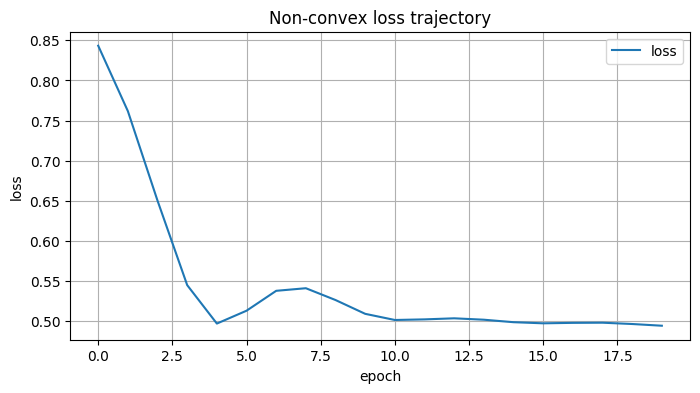

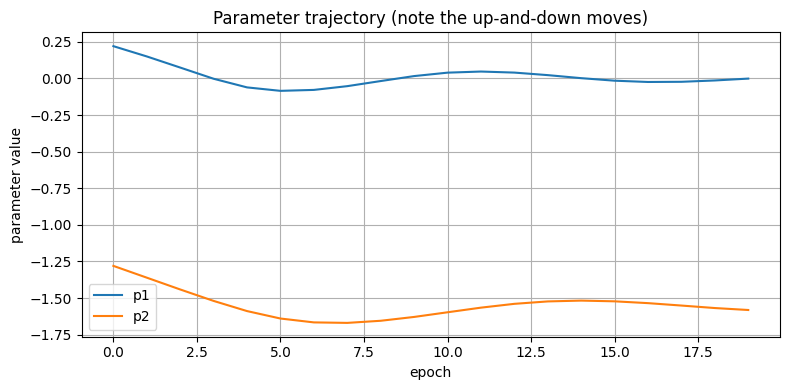

In [ ]:
#######################################################################
# 0.  imports & config
#######################################################################
import torch, math
from torchdiffeq import odeint                   # <- adaptive Radau
import matplotlib.pyplot as plt

torch.manual_seed(0)
device, dtype = 'cpu', torch.float64            # GPU works just as well

#######################################################################
# 1.  a “wiggly” ODE whose loss surface is strongly non-convex
#######################################################################
#
#     ẋ = p1 · x³  –  x  +  p2 · sin(3t)
#     L  = (x(T) – 0.7)²                     <- task performance
#        + 0.2·sin(5 p1)² + 0.2·cos(3 p2)²   <- bumpy regulariser
#
class WigglyODE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.p1 = torch.nn.Parameter(torch.tensor( 0.3, dtype=dtype))   # not at a min
        self.p2 = torch.nn.Parameter(torch.tensor(-1.2, dtype=dtype))   #   “   “   ”
    def forward(self, t, x):
        return (self.p1**3+self.p1**2+self.p1) * x**3 - x + self.p2 * torch.sin(3*t)

def simulate_and_loss(model, T=.5):
    t  = torch.linspace(0., T, 50, dtype=dtype, device=device)
    x0 = torch.tensor([0.25], dtype=dtype, device=device)
    x  = odeint(model, x0, t, method='radauIIA5_adaptive',
                rtol=1e-6, atol=1e-6)           # same solver you debug
    xT = x[-1, 0]
    perf = (xT - 0.7)**2
    reg  = 0.2*torch.sin(5*model.p1)**2 + 0.2*torch.cos(3*model.p2)**2
    return perf + reg

#######################################################################
# 2.  optimisation loop – watch loss & parameters wander
#######################################################################
net  = WigglyODE().to(device)
opt  = torch.optim.Adam(net.parameters(), lr=0.08, betas=(0.8, 0.99))

loss_hist, p1_hist, p2_hist = [], [], []

for epoch in range(20):
    opt.zero_grad()
    L = simulate_and_loss(net)
    L.backward()
    opt.step()

    # record trajectory
    loss_hist.append(L.item())
    p1_hist.append(net.p1.item())
    p2_hist.append(net.p2.item())

#######################################################################
# 3.  plots
#######################################################################
plt.figure(figsize=(8,4))
plt.plot(loss_hist, label='loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Non-convex loss trajectory')
plt.grid(True); plt.legend()

plt.figure(figsize=(8,4))
plt.plot(p1_hist, label='p1');  plt.plot(p2_hist, label='p2')
plt.xlabel('epoch'); plt.ylabel('parameter value')
plt.title('Parameter trajectory (note the up-and-down moves)')
plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
            t_vec, sol = sim.run_simulation_for_scenario('load_change')



--- Setting up scenario: load_change ---
Calculating default equilibrium target …
Converged with trf
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [ 88.25816872 -84.89081752  91.7943647  -67.20780351  88.19850704
 -85.09822197]…


In [ ]:
from collections import defaultdict, deque
grad_log = defaultdict(lambda: deque(maxlen=5))   # keeps last 5 signs/means

for n, p in sim.named_parameters():
    if p.grad is None:
        continue
    g = p.grad.detach()
    mean = g.mean().item()
    sign = torch.sign(g)
    unique = tuple(sign.unique(sorted=True).tolist())   # e.g. (-1.0,) or (-1.0, 1.0)
    grad_log[n].append(sign)

    # “flip ratio” = fraction of elements that changed sign vs previous epoch
    flip = float('nan')
    if len(grad_log[n]) >= 2:
        flip = (sign * grad_log[n][-2] < 0).float().mean().item()

    print(f"{n:8s}  ⟨|g|⟩={g.abs().mean():.3e}  sign={unique}  flip={flip:5.1%}")


eta       ⟨|g|⟩=4.555e+01  sign=(1.0,)  flip= nan%
eta_a     ⟨|g|⟩=2.790e-02  sign=(-1.0,)  flip= nan%
Kp_v      ⟨|g|⟩=1.602e+03  sign=(-1.0,)  flip= nan%
Ki_v      ⟨|g|⟩=1.234e-01  sign=(1.0,)  flip= nan%
Kp_f      ⟨|g|⟩=1.215e+02  sign=(-1.0,)  flip= nan%
Ki_f      ⟨|g|⟩=2.620e-03  sign=(1.0,)  flip= nan%
lambda_cond4  ⟨|g|⟩=1.980e+02  sign=(1.0,)  flip= nan%
lambda_cond5  ⟨|g|⟩=0.000e+00  sign=(0.0,)  flip= nan%
lambda_cond6  ⟨|g|⟩=0.000e+00  sign=(0.0,)  flip= nan%


In [ ]:
EPS = 1e-4
with torch.no_grad():
    for name, p in sim.named_parameters():
        if not p.requires_grad or p.grad is None:
            continue
        # finite-difference along +x
        p.data += EPS
        t1, s1 = sim.run_simulation_for_scenario("load_change")
        L_pos, *_ = sim.compute_lagrangian_loss(t1, s1)
        # finite-difference along –x
        p.data -= 2*EPS
        t2, s2 = sim.run_simulation_for_scenario("load_change")
        L_neg, *_ = sim.compute_lagrangian_loss(t2, s2)
        # restore
        p.data += EPS
        num_grad = (L_pos - L_neg) / (2*EPS)
        print(f"{name:8s}   autograd={p.grad.mean():+.3e}   num={num_grad:+.3e}")



--- Setting up scenario: load_change ---
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [84.07152888 89.05764767 66.12661584 92.24106872 84.58154345 88.92408326]…

--- Setting up scenario: load_change ---
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [117.22981954 -35.45380271 112.06093214 -17.97592351 117.33685957
 -35.96357738]…
eta        autograd=+4.555e+01   num=+5.277e+01

--- Setting up scenario: load_change ---
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [119.05121803 -29.31027172 112.87014884 -11.86834097 119.04349362
 -29.28749854]…

--- Setting up scenario: load_change ---
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [  27.11119548 -1

KeyboardInterrupt: 

In [ ]:
def finite_difference_grad(model, param, eps, scenario="load_change"):
    """
    Central finite difference dL/dθ for ONE scalar parameter tensor (no graph building).
    Keeps the cached equilibrium fixed so the surface is identical.
    """
    # helper that reuses the same equilibrium
    def forward_only():
        model._reuse_equilibrium = True
        t_vec, sol = model.run_simulation_for_scenario(scenario)
        return model.compute_lagrangian_loss(t_vec, sol)[0].detach()

    # baseline loss and param handle
    theta = param.data
    loss0 = forward_only()

    # +eps
    theta += eps
    loss_plus = forward_only()

    # -eps
    theta -= 2*eps
    loss_minus = forward_only()

    # restore
    theta += eps
    model._reuse_equilibrium = False   # turn it off again
    return (loss_plus - loss_minus) / (2*eps)


def gradient_check(model, eps=1e-4, verbose=True):
    rows = []
    model.zero_grad()
    # Build graph **once** (will also cache eq.)
    t_vec, sol = model.run_simulation_for_scenario("load_change")
    total_loss, *_ = model.compute_lagrangian_loss(t_vec, sol)
    total_loss.backward()

    for name, p in model.named_parameters():
        if p.grad is None or p.numel() != 1:    # check only scalars
            continue
        fd = finite_difference_grad(model, p, eps)
        ag = p.grad.detach().clone()
        rel_err = ((ag - fd).abs() / (fd.abs() + 1e-12)).item()
        agree = "✓" if rel_err < 1e-2 or torch.sign(ag) == torch.sign(fd) else "✗"
        rows.append((name, ag.item(), fd.item(), rel_err, agree))

    if verbose:
        print(f"{'name':10s} {'autograd':>12s} {'finite-diff':>12s} {'rel-err':>9s}  agree?")
        for n,a,f,e,s in rows:
            print(f"{n:10s} {a:+12.3e} {f:+12.3e} {e:9.1e}   {s}")
    return rows


In [ ]:
import torch, math
from torchdiffeq import odeint

# -------------------------------------------------------------------
# Toy model and loss  (identical to previous message)
# -------------------------------------------------------------------
class ToyStiffODE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.p1 = torch.nn.Parameter(torch.tensor(+0.8, dtype=torch.float64))
        self.p2 = torch.nn.Parameter(torch.tensor(+1.5, dtype=torch.float64))
    def forward(self, t, x):
        return self.p1 * x**3 - x + self.p2 * torch.sin(3*t)

def forward_sim_and_loss(model, T=2.0, device='cpu'):
    t = torch.linspace(0.0, T, 401, dtype=torch.float64, device=device)
    x0 = torch.tensor([0.2], dtype=torch.float64, device=device)
    x  = odeint(model, x0, t, method='radauIIA5_adaptive',
                rtol=1e-6, atol=1e-9)
    xT = x[-1, 0]
    perf = (xT - 0.7)**2
    reg  = 0.1 * model.p1**4 + 0.1 * torch.sin(4*model.p2)**2
    return perf + reg                             # scalar

# -------------------------------------------------------------------
# Gradient-check utility
# -------------------------------------------------------------------
def gradient_check(model, eps=1e-4, tol=1e-2, device='cpu'):
    """Compare autograd gradient with central finite difference."""
    # 1) one forward pass builds the graph
    loss0 = forward_sim_and_loss(model, device=device)
    loss0.backward()                       # autograd grads now in .grad

    print(f"{'param':>6s} | {'autograd':>12s} | {'finite diff':>12s} | {'rel-err':>8s} | ok?")
    print("-"*60)

    for name, p in model.named_parameters():
        if p.grad is None or p.numel() != 1:
            continue                       # skip non-scalar params

        # 2) finite difference on *frozen* graph
        with torch.no_grad():
            p += eps
        lp = forward_sim_and_loss(model, device=device)

        with torch.no_grad():
            p -= 2*eps
        lm = forward_sim_and_loss(model, device=device)

        with torch.no_grad():
            p += eps                       # restore

        fd = (lp - lm) / (2*eps)
        ag = p.grad.item()
        rel = abs(ag - fd.item()) / (abs(fd) + 1e-12)
        print(f"{name:6s} | {ag:+12.4e} | {fd.item():+12.4e} | {rel:8.1e} | "
              f"{'✓' if rel < tol else '✗'}")

    # clear grads so optimiser can proceed afterwards
    for p in model.parameters():
        if p.grad is not None:
            p.grad.zero_()

# -------------------------------------------------------------------
# Example usage
# -------------------------------------------------------------------
device = 'cpu'          # or 'cuda' if GPU available
toy = ToyStiffODE().to(device)
gradient_check(toy, eps=1e-4, tol=1e-2, device=device)


 param |     autograd |  finite diff |  rel-err | ok?
------------------------------------------------------------
p1     |  -3.1772e-01 |  -3.1780e-01 |  2.3e-04 | ✓
p2     |  -2.7346e-01 |  -2.7397e-01 |  1.9e-03 | ✓


In [ ]:
############################################################
# 0.  imports
############################################################
import torch, math, numpy as np
from torchdiffeq import odeint

torch.manual_seed(0)
device, dtype = 'cpu', torch.float64       # works on GPU too

############################################################
# 1.  the toy ODE as a nn.Module so parameters require_grad
############################################################
class ToyODE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.p1 = torch.nn.Parameter(torch.tensor(+0.8, dtype=dtype))   # start on left flank
        self.p2 = torch.nn.Parameter(torch.tensor(+1.5, dtype=dtype))   # off a sine valley
    def forward(self, t, x):
        return self.p1 * x**3 - x + self.p2 * torch.sin(3*t)

############################################################
# 2.  objective  L(p1,p2)
############################################################
def simulate_and_loss(model, T=2.0):
    t = torch.linspace(0.0, T, 201, dtype=dtype, device=device)
    x0 = torch.tensor([0.2], dtype=dtype, device=device)
    x  = odeint(model, x0, t, method='dopri5')  # shape [steps,1]
    xT = x[-1,0]
    x_star = torch.tensor(0.7, dtype=dtype, device=device)
    perf = (xT - x_star)**2
    reg  = 0.1*model.p1**4 + 0.1*torch.sin(4*model.p2)**2
    return (perf + reg), perf.detach(), reg.detach()

############################################################
# 3.  optimisation loop with sign logging
############################################################
model  = ToyODE().to(device)
opt    = torch.optim.Adam(model.parameters(), lr=0.05, betas=(0.5,0.999))

prev_sign = {n: None for n,_ in model.named_parameters()}

for epoch in range(25):
    opt.zero_grad()
    loss, perf, reg = simulate_and_loss(model)
    loss.backward()

    # ---- print sign-flip information
    msgs = []
    for n,p in model.named_parameters():
        s = torch.sign(p.grad.detach()).item()
        flip = (prev_sign[n] is not None) and (s != prev_sign[n])
        prev_sign[n] = s
        msgs.append(f"{n} {'flip' if flip else '    '}")

    print(f"epoch {epoch:02d} | loss={loss.item():8.4f} | "
          f"{' | '.join(msgs)}")

    opt.step()


epoch 00 | loss=  1.0013 | p1      | p2     
epoch 01 | loss=  0.9661 | p1      | p2     
epoch 02 | loss=  0.9092 | p1      | p2     
epoch 03 | loss=  0.7925 | p1      | p2     
epoch 04 | loss=  0.4300 | p1      | p2     


AssertionError: underflow in dt 1.0313615728434908e-16

In [ ]:
# =========================================================
# 0.  Imports & configuration
# =========================================================
import torch, math
from torchdiffeq import odeint
torch.manual_seed(0)
device, dtype = 'cpu', torch.float64        # switch to 'cuda' if you like

# =========================================================
# 1.  A stiff(ish) scalar ODE with two learnable parameters
#     dx/dt = p1 * x^3 - x + p2 * sin(3t)
# =========================================================
class ToyStiffODE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.p1 = torch.nn.Parameter(torch.tensor(+0.8, dtype=dtype))
        self.p2 = torch.nn.Parameter(torch.tensor(+1.5, dtype=dtype))
    def forward(self, t, x):
        return self.p1 * x**3 - x + self.p2 * torch.sin(3*t)

# =========================================================
# 2.  Loss = squared terminal error  +  non-convex penalty
# =========================================================
def forward_sim_and_loss(model, T=2.0):
    t_grid = torch.linspace(0.0, T, 401, dtype=dtype, device=device)
    x0     = torch.tensor([0.2], dtype=dtype, device=device)
    x      = odeint(model, x0, t_grid,
                    method='radauIIA5_adaptive', rtol=1e-6, atol=1e-9)
    xT     = x[-1, 0]
    perf   = (xT - 0.7)**2
    reg    = 0.1 * model.p1.pow(4) + 0.1 * torch.sin(4.0 * model.p2).pow(2)
    return perf + reg, perf.detach(), reg.detach()

# =========================================================
# 3.  Helper: central finite difference on *frozen graph*
# =========================================================
def finite_diff(model, param, eps=1e-4):
    theta = param.data
    loss0, *_ = forward_sim_and_loss(model)      # build graph once

    with torch.no_grad():
        theta += eps
    lp, *_ = forward_sim_and_loss(model)

    with torch.no_grad():
        theta -= 2*eps
    lm, *_ = forward_sim_and_loss(model)

    with torch.no_grad():
        theta += eps                            # restore
    return (lp - lm) / (2*eps)

# =========================================================
# 4.  Optimisation loop with gradient-sign tracker
# =========================================================
model = ToyStiffODE().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=0.05, betas=(0.5, 0.999))

prev_sign = {}

print(f"{'epoch':>5s} | {'loss':>10s} |  grad-p1  flip? |  grad-p2  flip? |  fd-match?")
for epoch in range(15):
    opt.zero_grad()
    loss, perf, reg = forward_sim_and_loss(model)
    loss.backward()

    # ----- sign & FD diagnostics ------------------------------------
    row = [f"{epoch:5d}", f"{loss.item():10.4f}"]

    fd_ok = True
    for name, p in model.named_parameters():
        g     = p.grad.detach().clone()
        sgn   = int(torch.sign(g).item())
        flip  = (name in prev_sign) and (prev_sign[name] != sgn)
        prev_sign[name] = sgn

        fd    = finite_diff(model, p)           # uses same radau + frozen graph
        rel   = (g - fd).abs() / (fd.abs() + 1e-12)
        fd_ok = fd_ok and (rel.item() < 1e-2)   # ~1 % tolerance

        row.append(f"{g.item():+9.2e} {'✓' if flip else ' '}")
    row.append("✓" if fd_ok else "✗")
    print(" | ".join(row))

    opt.step()


epoch |       loss |  grad-p1  flip? |  grad-p2  flip? |  fd-match?
    0 |     1.0013 | -3.18e-01   | -2.73e-01   | ✓
    1 |     0.9661 | -4.76e-01   | -3.74e-01   | ✗


KeyboardInterrupt: 

In [ ]:
############################################################
# 0.  imports
############################################################
import torch, math, numpy as np
from torchdiffeq import odeint

torch.manual_seed(0)
device, dtype = 'cpu', torch.float64       # works on GPU too

############################################################
# 1.  the toy ODE as a nn.Module so parameters require_grad
############################################################
class ToyODE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.p1 = torch.nn.Parameter(torch.tensor(+0.8, dtype=dtype))   # start on left flank
        self.p2 = torch.nn.Parameter(torch.tensor(+1.5, dtype=dtype))   # off a sine valley
    def forward(self, t, x):
        return self.p1 * x - x + self.p2 * torch.sin(3*t)

############################################################
# 2.  objective  L(p1,p2)
############################################################
def simulate_and_loss(model, T=2.0):
    t = torch.linspace(0.0, T, 201, dtype=dtype, device=device)
    x0 = torch.tensor([0.2], dtype=dtype, device=device)
    x  = odeint(model, x0, t, method='radau')  # shape [steps,1]
    xT = x[-1,0]
    x_star = torch.tensor(0.7, dtype=dtype, device=device)
    perf = (xT - x_star)**2
    reg  = 0.1*model.p1**4 + 0.1*torch.sin(4*model.p2)**2
    return (perf + reg), perf.detach(), reg.detach()

############################################################
# 3.  optimisation loop with sign logging
############################################################
model  = ToyODE().to(device)
opt    = torch.optim.Adam(model.parameters(), lr=0.05, betas=(0.5,0.999))

prev_sign = {n: None for n,_ in model.named_parameters()}

for epoch in range(25):
    opt.zero_grad()
    loss, perf, reg = simulate_and_loss(model)
    loss.backward()

    # ---- print sign-flip information
    msgs = []
    for n,p in model.named_parameters():
        s = torch.sign(p.grad.detach()).item()
        flip = (prev_sign[n] is not None) and (s != prev_sign[n])
        prev_sign[n] = s
        msgs.append(f"{n} {'flip' if flip else '    '}")

    print(f"epoch {epoch:02d} | loss={loss.item():8.4f} | "
          f"{' | '.join(msgs)}")

    opt.step()


KeyboardInterrupt: 

In [ ]:
    sim = MultiConverterSimulation(device=device, dtype=dtype)


<ipython-input-7-ef5465265c34>:717: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.original_rL           = torch.tensor(self.network.rL.clone().detach(),dtype=self.dtype, device=self.device)


In [ ]:
def perf_only_gradients(sim):
    t, sol = sim.run_simulation_for_scenario("load_change")

    # plain performance loss (no hinge, no λ)
    loss_perf = sim.compute_loss(t, sol)        # your voltage-error fn
    sim.zero_grad()
    loss_perf.backward()

    grads = {n: p.grad.detach().clone()
             for n,p in sim.named_parameters() if p.grad is not None}

    # quick print
    for n,g in grads.items():
        print(f"{n:7s}  g_perf={g.item():+9.2e}")
    return grads, t, sol


In [ ]:
g_perf, t_vec, sol = perf_only_gradients(sim)



--- Setting up scenario: load_change ---
Calculating default equilibrium target …
Converged with trf
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [ 88.25816872 -84.89081752  91.7943647  -67.20780351  88.19850704
 -85.09822197]…


/usr/local/lib/python3.11/dist-packages/torchdiffeq/_impl/rk_common.py:468: UserWarning: Functional iteration did not converge. Solution may be incorrect.
  warnings.warn('Functional iteration did not converge. Solution may be incorrect.')


eta      g_perf=+6.00e+91
eta_a    g_perf=+3.29e+91
Kp_v     g_perf=-3.41e+93
Ki_v     g_perf=+2.69e+89
Kp_f     g_perf=-6.65e+92
Ki_f     g_perf=+1.54e+88


In [ ]:
#######################################################################
# 0. configuration
#######################################################################
EPS = 1e-6              # parameter perturbation
sim = MultiConverterSimulation(device=device, dtype=dtype)

device = next(sim.parameters()).device

#######################################################################
# 1. run a baseline forward pass (build graph once)
#######################################################################
t0, sol0 = sim.run_simulation_for_scenario("load_change")
loss0, *_ = sim.compute_lagrangian_loss(t0, sol0)      # full loss or perf-only
sim.zero_grad()
loss0.backward()

print(f"{'param':7s} | autograd⋅Δ |  Δloss  | ratio ")
print("-"*46)

#######################################################################
# 2. loop over each scalar learnable parameter
#######################################################################
for name, p in sim.named_parameters():

    if p.grad is None or p.numel() != 1:
        continue

    # ----- predicted change from gradient ----------------------------
    grad_dir = p.grad.item()
    pred_dL  = grad_dir * EPS          # first-order Taylor

    # ----- finite-difference loss change -----------------------------
    with torch.no_grad():
        p += EPS
    t1, sol1 = sim.run_simulation_for_scenario("load_change")
    loss1, *_ = sim.compute_lagrangian_loss(t1, sol1)

    with torch.no_grad():
        p -= EPS                       # restore

    fd_dL = (loss1 - loss0).item()

    # ----- ratio ------------------------------------------------------
    ratio = float('inf') if pred_dL == 0 else fd_dL / pred_dL

    print(f"{name:7s} | {pred_dL:+10.3e} | {fd_dL:+10.3e} | {ratio:6.2f}")


<ipython-input-7-fde7fd890164>:717: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.original_rL           = torch.tensor(self.network.rL.clone().detach(),dtype=self.dtype, device=self.device)



--- Setting up scenario: load_change ---
Calculating default equilibrium target …
Converged with trf
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [ 88.25816872 -84.89081752  91.7943647  -67.20780351  88.19850704
 -85.09822197]…
param   | autograd⋅Δ |  Δloss  | ratio 
----------------------------------------------

--- Setting up scenario: load_change ---
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [ -55.71470797 -109.04344856  -37.77650315 -107.31292084  -55.95357677
 -109.04679804]…
eta     | +7.603e-06 | +7.605e-06 |   1.00

--- Setting up scenario: load_change ---
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [-120.4998614    21.77991519 -113.65305148    5.10992888 -120.57229558
   22.00793585]…
eta_a   | -4.150e-09 | -2.481e

In [ ]:
grad = pred_dL / EPS        # true ∂L/∂θ
print(f"{name}  grad = {grad:+.3e}")


lambda_cond6  grad = +0.000e+00


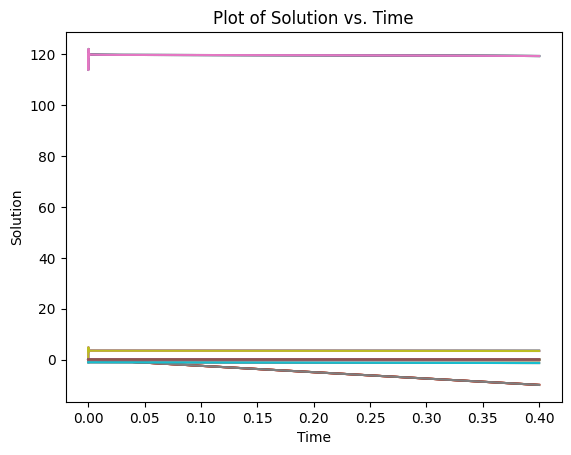

In [ ]:
# prompt: plot t_vec and sol noting they are torch

import matplotlib.pyplot as plt

plt.plot(t_vec.cpu().detach().numpy(), sol.cpu().detach().numpy())
plt.xlabel("Time")
plt.ylabel("Solution")
plt.title("Plot of Solution vs. Time")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming t_vec, sol, and sol1 are your data
# Get the number of columns from the solution data
num_columns = sol.shape[1]

# Create subplots - adjust the figure size based on number of columns
# For many columns, a grid layout might be better
rows = min(8, num_columns)  # Maximum 5 rows, then create multiple columns
cols = int(np.ceil(num_columns / rows))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten() if num_columns > 1 else [axes]

# Convert tensors to numpy once to avoid repetition
t_numpy = t_vec.cpu().detach().numpy()
sol_numpy = sol.cpu().detach().numpy()
sol1_numpy = sol1.cpu().detach().numpy()

# Loop through the columns and plot
for i in range(num_columns):
    # Plot both sol and sol1 on the same subplot
    axes[i].plot(t_numpy, sol_numpy[:, i], label='sol')
    axes[i].plot(t_numpy, sol1_numpy[:, i], label='sol1')

    # Add labels
    axes[i].set_ylabel(f"Column {i}")
    axes[i].set_title(f"Column {i}")
    axes[i].legend()
    axes[i].grid(True)

# Hide any unused subplots
for i in range(num_columns, len(axes)):
    axes[i].set_visible(False)

# Add a common x-label to the figure
fig.text(0.5, 0.04, "Time", ha='center', va='center', fontsize=12)

# Add a title to the overall figure
fig.suptitle("Plot of Solutions vs. Time for All Columns", fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.08)  # Make room for suptitle and xlabel

# Show the plot
plt.show()

In [ ]:
plt.plot(t_vec.cpu().detach().numpy(), sol[:,0+6+6].cpu().detach().numpy())
plt.plot(t_vec.cpu().detach().numpy(), sol1[:,0+6+6].cpu().detach().numpy())

plt.xlabel("Time")
plt.ylabel("Solution")
plt.title("Plot of Solution vs. Time")
plt.show()

In [ ]:
simo.converter.setpoints

Setpoints(v_star=tensor([120., 120., 120.], device='cuda:0', dtype=torch.float64), p_star=tensor([43.2000, 41.0000, 41.0000], device='cuda:0', dtype=torch.float64), q_star=tensor([-0.9000,  0.5000, -0.5000], device='cuda:0', dtype=torch.float64), theta_star=tensor([0., 0., 0.], device='cuda:0', dtype=torch.float64))

In [ ]:
plt.plot(t_vec.cpu().detach().numpy(), sol[:,0+6+6].cpu().detach().numpy())
plt.xlabel("Time")
plt.ylabel("Solution")
plt.title("Plot of Solution vs. Time")
plt.show()

In [ ]:
    sim = MultiConverterSimulation(device=device, dtype=dtype)


In [ ]:
            t_vec, sol = sim.run_simulation_for_scenario("load_change")



--- Setting up scenario: load_change ---
Scenario 'load_change': rL = 5.7500 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [116.50104219 -14.81473862 105.72316683 -58.36056449 105.7276233
 -58.35004685]…


In [ ]:
a=12
q=torch.sqrt(sol[:,a]**2+sol[:,a+1]**2)
#q2=torch.sqrt(sol1[:,a]**2+sol1[:,a+1]**2)


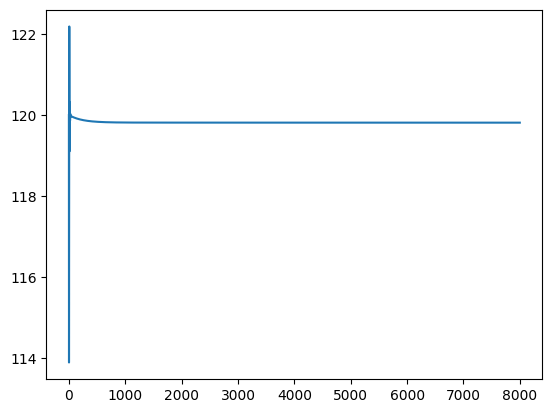

In [ ]:
plt.plot(q.cpu().detach().numpy())
#plt.plot(q2.cpu().detach().numpy())


In [ ]:
plt.plot(q2.cpu().detach().numpy())


In [ ]:
sim.compute_equilibrium_point()

In [ ]:
q[-1]

tensor(119.8126, device='cuda:0', dtype=torch.float64)

In [ ]:
target_equilibrium = sim.scenario_equilibrium_targets.get(sim.scenario)

In [ ]:
target_equilibrium

In [ ]:
sim.network.rL=115

In [ ]:
a=sim.compute_equilibrium_point()

Converged with trf


In [ ]:
a.shape

torch.Size([36])

In [ ]:
#######################################################################
# 0. configuration
#######################################################################
EPS = 1e-6               # parameter perturbation
device = next(sim.parameters()).device

#######################################################################
# 1. run a baseline forward pass (build graph once)
#######################################################################
t0, sol0 = sim.run_simulation_for_scenario("load_change")
loss0, *_ = sim.compute_lagrangian_loss(t0, sol0)      # full loss or perf-only
sim.zero_grad()
loss0.backward()

print(f"{'param':7s} | autograd⋅Δ |  Δloss  | ratio ")
print("-"*46)

#######################################################################
# 2. loop over each scalar learnable parameter
#######################################################################
for name, p in sim.named_parameters():

    if p.grad is None or p.numel() != 1:
        continue

    # ----- predicted change from gradient ----------------------------
    grad_dir = p.grad.item()
    pred_dL  = grad_dir * EPS          # first-order Taylor

    # ----- finite-difference loss change -----------------------------
    with torch.no_grad():
        p += EPS
    t1, sol1 = sim.run_simulation_for_scenario("load_change")
    loss1, *_ = sim.compute_lagrangian_loss(t1, sol1)

    with torch.no_grad():
        p -= EPS                       # restore

    fd_dL = (loss1 - loss0).item()

    # ----- ratio ------------------------------------------------------
    ratio = float('inf') if pred_dL == 0 else fd_dL / pred_dL

    print(f"{name:7s} | {pred_dL:+10.3e} | {fd_dL:+10.3e} | {ratio:6.2f}")



--- Setting up scenario: load_change ---
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [ 88.25816872 -84.89081752  91.7943647  -67.20780351  88.19850704
 -85.09822197]…


/usr/local/lib/python3.11/dist-packages/torchdiffeq/_impl/misc.py:15: UserWarning: AdaptiveRadauIIA5: Unexpected arguments {'dt_min': 1e-08}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


param   | autograd⋅Δ |  Δloss  | ratio 
----------------------------------------------

--- Setting up scenario: load_change ---
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [ -55.71470797 -109.04344856  -37.77650315 -107.31292084  -55.95357677
 -109.04679804]…
eta     | +4.789e+00 | -1.065e+04 | -2224.59

--- Setting up scenario: load_change ---
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [-120.4998614    21.77991519 -113.65305148    5.10992888 -120.57229558
   22.00793585]…
eta_a   | -1.729e+01 | +5.005e+04 | -2894.68

--- Setting up scenario: load_change ---
Scenario 'load_change': rL = 11.5000 Ω
Converged with trf
  … new equilibrium accepted (‖F‖<1e‑4).
Target equilibrium used by LOSS: [-14.1508982  121.63193322 -28.11423174 110.23936366 -13.95364957
 121.76752305]…
Kp_v    | +1.539e+03 | +1.416e+04 |   9.21


In [ ]:

        # Handle dimensions with/without line currents
        Nc, Nt = sim.network.Nc, sim.network.Nt
        n_conv, n_line = 2 * Nc, 2 * Nt

        # Standardize state vector (remove line currents if present)
        if sim.integrate_line_dynamics:
            # Format: [vhat, i_line, v, zeta_v, i_f, zeta_f]
            vhat_indices = slice(0, n_conv)
            v_indices = slice(n_conv + n_line, 2*n_conv + n_line)
        else:
            # Format: [vhat, v, zeta_v, i_f, zeta_f]
            vhat_indices = slice(0, n_conv)
            v_indices = slice(n_conv, 2*n_conv)

        # Extract voltage components
        vhat_sol = sol[:, vhat_indices].reshape(-1, Nc, 2)  # reshape to [time, converters, αβ]
        v_sol = sol[:, v_indices].reshape(-1, Nc, 2)       # reshape to [time, converters, αβ]

        # Get voltage setpoints
        v_star = sim.converter.setpoints.v_star  # [Nc]

        # Compute voltage magnitudes
        vhat_mag_sol = torch.norm(vhat_sol, dim=2)  # [time, Nc]
        v_mag_sol = torch.norm(v_sol, dim=2)        # [time, Nc]

        # Calculate magnitude deviations directly from v*
        vhat_dev = (vhat_mag_sol - v_star.unsqueeze(0)) / v_star.unsqueeze(0)
        v_dev = (v_mag_sol - v_star.unsqueeze(0)) / v_star.unsqueeze(0)

        # Calculate L-infinity norm (maximum absolute deviation)
        vhat_loss = torch.max(torch.abs(vhat_dev))
        v_loss = torch.max(torch.abs(v_dev))

        # Add peak oscillation measure for latter part of simulation
        num_steps = sol.shape[0]
        latter_half_idx = num_steps // 2
        v_mag_latter = v_mag_sol[latter_half_idx:, :]

        # Maximum peak-to-peak deviation for each converter in latter half
        peak_to_peak = torch.max(v_mag_latter, dim=0)[0] - torch.min(v_mag_latter, dim=0)[0]
        oscillation_penalty = torch.max(peak_to_peak) / torch.mean(v_star)

        # Weight components (emphasize terminal voltage v over reference vhat)
        total_loss = 3.0 * vhat_loss + 10.0 * v_loss

        # Ensure we maintain gradients
        if sol.requires_grad and not total_loss.requires_grad:
            total_loss = total_loss + 0.0 * sol.sum()


In [ ]:
vhat_indices

slice(0, 6, None)

In [ ]:
torch.max(v_dev)

tensor(0.0714, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)

In [ ]:
v_loss

tensor(0.0742, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)

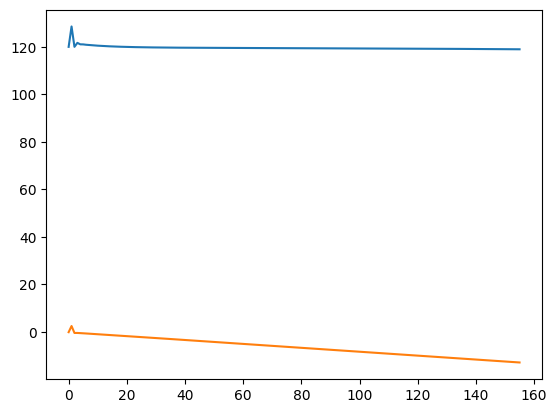

In [ ]:
plt.plot(sol[:, v_indices][:,0:2].cpu().detach().numpy())

In [ ]:
np.max(sol[:, v_indices][:,0:2].cpu().detach().numpy())

np.float64(128.5465859421806)

In [ ]:
import numpy as np
import torch

def differentiable_process_results(t_vec, sol, converter_indices=None, network_omega0=2*np.pi*60):
    """
    Differentiable implementation of frequency calculation for dq-frame power systems.
    Takes the same inputs as the original process_results method for drop-in compatibility.

    Args:
        t_vec: Time vector (numpy array or torch tensor)
        sol: Solution array from ODE solver (numpy array or torch tensor)
        converter_indices: Dict of indices for different state variables. If None, uses default indices.
        network_omega0: Base angular frequency in rad/s (default: 2π × 60 Hz)

    Returns:
        Dictionary containing results with torch tensors (compatible with autograd)
    """
    # Convert inputs to PyTorch tensors if they aren't already
    if not isinstance(t_vec, torch.Tensor):
        t_vec = torch.tensor(t_vec, dtype=torch.float32)
    if not isinstance(sol, torch.Tensor):
        sol = torch.tensor(sol, dtype=torch.float32)

    # Set up differentiable calculation parameters
    omega_0 = network_omega0
    f_0 = omega_0 / (2 * np.pi)

    # Small constants for numerical stability
    EPS = 1e-8

    # Filtering parameters
    alpha_initial = 0.05  # Strong filtering during startup
    alpha_normal = 0.2    # Normal operation filtering
    beta = 10.0           # Controls sharpness of soft transitions

    # Setup indices if not provided
    if converter_indices is None:
        # Default indices based on the original implementation
        Nc = 3  # Number of converters
        Nt = 3  # Number of transmission lines
        n_conv = 2*Nc
        n_line = 2*Nt

        # Define slicing indices
        off_vhat = 0
        off_iline = n_conv
        off_v = off_iline + n_line
        off_zeta_v = off_v + n_conv
        off_if = off_zeta_v + n_conv
        off_zeta_f = off_if + n_conv
    else:
        # Use provided indices
        Nc = converter_indices['Nc']
        off_vhat = converter_indices['off_vhat']
        off_v = converter_indices['off_v']
        off_if = converter_indices['off_if']

    # Initialize output arrays - use PyTorch tensors for gradient tracking
    nsamples = len(t_vec)
    voltage_mag = torch.zeros((nsamples, Nc), dtype=torch.float32)
    freq = torch.zeros((nsamples, Nc), dtype=torch.float32)
    p_out = torch.zeros((nsamples, Nc), dtype=torch.float32)
    q_out = torch.zeros((nsamples, Nc), dtype=torch.float32)

    # Additional diagnostic arrays
    vhat_freq = torch.zeros((nsamples, Nc), dtype=torch.float32)
    v_freq = torch.zeros((nsamples, Nc), dtype=torch.float32)

    # Initialize with base frequency
    freq[:, :] = f_0
    vhat_freq[:, :] = f_0
    v_freq[:, :] = f_0

    # Calculate startup cutoff for adaptive filtering
    startup_cutoff = int(nsamples * 0.05)

    # Define differentiable helper functions
    def soft_sig(x):
        """Differentiable sigmoid activation"""
        return torch.sigmoid(beta * x)

    def soft_threshold(x, threshold):
        """Soft thresholding with gradients"""
        return soft_sig(x - threshold)

    def soft_clip(x, min_val, max_val):
        """Soft clipping function that maintains gradients"""
        x_clipped_min = x + torch.log1p(torch.exp(beta * (min_val - x))) / beta
        x_clipped = x_clipped_min - torch.log1p(torch.exp(beta * (x_clipped_min - max_val))) / beta
        return x_clipped

    def diff_phase_unwrap(phase_diff):
        """Differentiable phase unwrapping"""
        wrapped_up = soft_sig(phase_diff - np.pi) * 2 * np.pi
        wrapped_down = soft_sig(-phase_diff - np.pi) * 2 * np.pi
        return phase_diff - wrapped_up + wrapped_down

    def diff_validity_weight(freq_val, nominal, valid_range):
        """Differentiable validity weight calculation"""
        deviation = torch.abs(freq_val - nominal)
        return torch.exp(-beta * torch.relu(deviation - valid_range))

    # Process each time step
    prev_v = None
    prev_vhat = None
    prev_time = t_vec[0]
    if len(t_vec) == 0:
        # Handle empty input case if necessary, e.g., return empty results
        return { # Return structure matching the normal output
            'time': t_vec,
            'voltage_mag': torch.zeros((0, Nc), dtype=torch.float32),
            'frequency': torch.zeros((0, Nc), dtype=torch.float32),
            'active_power': torch.zeros((0, Nc), dtype=torch.float32),
            'reactive_power': torch.zeros((0, Nc), dtype=torch.float32),
            'v_freq': torch.zeros((0, Nc), dtype=torch.float32),
            'vhat_freq': torch.zeros((0, Nc), dtype=torch.float32)
        }
    prev_time = t_vec[0]

    # Convert beta to a tensor for consistency if desired, though not strictly required here
    # beta_t = torch.tensor(beta, dtype=torch.float32, device=t_vec.device) # Optional
    # Or keep beta as float, PyTorch often handles float * tensor

    for k in range(nsamples):
        # Get current state
        statek = sol[k, :]
        vhat = statek[off_vhat:off_vhat + n_conv]
        v_nodes = statek[off_v:off_v + n_conv]
        i_f = statek[off_if:off_if + n_conv]

        # Current time and delta time
        current_time = t_vec[k]
        # Ensure dt is a tensor, especially for the k=0 case
        if k > 0:
            # Difference between tensor elements results in a tensor scalar
            dt = current_time - prev_time
            # Add a small epsilon to dt only if it's exactly zero to avoid division by zero
            # but retain gradients. Using torch.where is differentiable.
            dt_safe = torch.where(dt <= 0, torch.tensor(EPS, dtype=dt.dtype, device=dt.device), dt)
        else:
            # Initialize dt as a tensor for the first step
            dt = torch.tensor(0.0001, dtype=t_vec.dtype, device=t_vec.device) # Use input tensor's dtype and device
            dt_safe = dt # Already non-zero

        # Determine adaptive filtering strength - differentiable version
        # --- FIX STARTS HERE ---
        # Calculate time_progress as a float first
        time_progress_float = float(k / startup_cutoff) if startup_cutoff > 0 else 1.0
        # Convert time_progress to a tensor
        time_progress = torch.tensor(time_progress_float, dtype=t_vec.dtype, device=t_vec.device)

        # Now -beta * time_progress will result in a tensor because time_progress is a tensor
        # (assuming beta remains a float, PyTorch handles float * tensor -> tensor)
        # Or use beta_t if defined: startup_weight = torch.exp(-beta_t * time_progress)
        startup_weight = torch.exp(-beta * time_progress)
        # --- FIX ENDS HERE ---

        alpha = alpha_initial * startup_weight + alpha_normal * (1 - startup_weight)

        # Process each converter
        for i in range(Nc):
            idx_slice = slice(2*i, 2*(i+1))
            v_dq = v_nodes[idx_slice]
            vhat_dq = vhat[idx_slice]
            i_f_dq = i_f[idx_slice]

            # Calculate voltage magnitude (differentiable norm)
            voltage_mag[k, i] = torch.sqrt(torch.sum(v_dq**2) + EPS)

            # Calculate phase angles
            v_phase_current = torch.atan2(v_dq[1], v_dq[0])
            vhat_phase_current = torch.atan2(vhat_dq[1], vhat_dq[0])

            # Only proceed with calculations if we have previous values
            if k > 0:
                # Voltage significance check - differentiable version
                v_significant = soft_threshold(voltage_mag[k, i], 5.0)

                # 1. vhat-based calculation
                prev_vhat_dq = prev_vhat[idx_slice]
                # Use dt_safe for division
                dvhat_dt = (vhat_dq - prev_vhat_dq) / dt_safe

                vhat_magnitude = torch.sqrt(torch.sum(vhat_dq**2) + EPS)
                vhat_significant = soft_threshold(vhat_magnitude, 0.05) # Note: vhat_significant isn't used later?

                # Cross product for rotation term
                rotation_term = (vhat_dq[0] * dvhat_dt[1] - vhat_dq[1] * dvhat_dt[0])
                # Normalize with safe division
                norm_rotation = rotation_term / (vhat_magnitude**2 + EPS)
                # Scale to frequency (assuming f_0 is already a tensor)
                vhat_freq_val = f_0 + norm_rotation / (2 * torch.pi) # Use torch.pi
                vhat_freq[k, i] = vhat_freq_val

                # 2. Voltage phase change calculation
                prev_v_phase = torch.atan2(prev_v[idx_slice][1], prev_v[idx_slice][0])
                phase_diff = v_phase_current - prev_v_phase

                # Differentiable phase unwrapping (use torch.pi)
                phase_diff_unwrapped = diff_phase_unwrap(phase_diff) # Make sure diff_phase_unwrap uses torch.pi internally

                # Convert to frequency (Use dt_safe)
                v_freq_val = f_0 + phase_diff_unwrapped / (2 * torch.pi * dt_safe)
                v_freq[k, i] = v_freq_val

                # 3. Hybrid approach - differentiable version
                # Validity weights (assuming diff_validity_weight handles tensors)
                vhat_valid = diff_validity_weight(vhat_freq_val, f_0, 2.0)
                v_valid = diff_validity_weight(v_freq_val, f_0, 2.0)

                # Soft clipping (assuming soft_clip handles tensors)
                v_freq_clipped = soft_clip(v_freq_val, f_0 - 1.0, f_0 + 1.0)
                vhat_freq_clipped = soft_clip(vhat_freq_val, f_0 - 1.0, f_0 + 1.0)

                # Normalized weights with soft transitions
                total_weight = vhat_valid + v_valid + EPS
                norm_vhat_weight = vhat_valid / total_weight
                norm_v_weight = v_valid / total_weight

                # Weight by startup vs. steady state
                method_weight = startup_weight * norm_vhat_weight + (1 - startup_weight) * norm_v_weight

                # Combine methods
                combined_freq = method_weight * vhat_freq_clipped + (1 - method_weight) * v_freq_clipped

                # Gate by voltage significance
                inst_freq = v_significant * combined_freq + (1 - v_significant) * f_0

                # Low-pass filter - differentiable (alpha is now tensor)
                freq[k, i] = alpha * inst_freq + (1 - alpha) * freq[k-1, i]

                # Calculate powers in dq-frame - differentiable
                i_total = -i_f_dq
                p_out[k, i] = v_dq[0] * i_total[0] + v_dq[1] * i_total[1]
                q_out[k, i] = v_dq[1] * i_total[0] - v_dq[0] * i_total[1]
            else:
                # Initialize powers in first step (k=0)
                # Frequencies are already initialized to f_0
                i_total = -i_f_dq
                p_out[k, i] = v_dq[0] * i_total[0] + v_dq[1] * i_total[1]
                q_out[k, i] = v_dq[1] * i_total[0] - v_dq[0] * i_total[1]

        # Store current values for next iteration
        # Ensure cloning for tensors to avoid modifying previous state inadvertently if needed,
        # though direct assignment might be fine if statek components are distinct slices.
        # .clone().detach() if you don't want gradient history through prev_v/prev_vhat
        prev_v = v_nodes.clone()
        prev_vhat = vhat.clone()
        prev_time = current_time

    # No post-processing smoothing as it's not differentiable
    # Instead, we rely on the low-pass filtering during the main calculation

    return {
        'time': t_vec,
        'voltage_mag': voltage_mag,
        'frequency': freq,
        'active_power': p_out,
        'reactive_power': q_out,
        'v_freq': v_freq,
        'vhat_freq': vhat_freq
    }



In [ ]:
results=differentiable_process_results(torch.tensor(t_vec), torch.tensor(sol), converter_indices=None, network_omega0=torch.tensor(2*np.pi*60))

<ipython-input-26-2e782589ff30>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  results=differentiable_process_results(torch.tensor(t_vec), torch.tensor(sol), converter_indices=None, network_omega0=torch.tensor(2*np.pi*60))


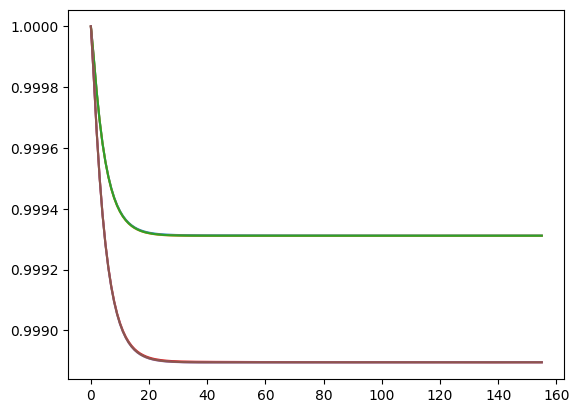

In [ ]:
plt.plot(results['frequency']/60)
plt.plot(resultso['frequency']/60)

plt.show()

In [ ]:
resultso=results

In [ ]:
resultso['frequency'][-1]

tensor([59.9337, 59.9337, 59.9337])

In [ ]:
results['frequency'][-1]

tensor([59.9587, 59.9587, 59.9587])